I'm practicing match-specific data viz and dashboards using Whoscored data, focusing on the Chelsea 4 - 4 Man City game on November 12 2023: https://www.whoscored.com/Matches/1729243/Live/England-Premier-League-2023-2024-Chelsea-Manchester-City

# Scraping and Preparing the Data

## Scraping some basic match statistics

In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd

In [2]:
url = 'https://www.whoscored.com/Matches/1729243/Live/England-Premier-League-2023-2024-Chelsea-Manchester-City'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/116.0'}
page = requests.get(url,headers=headers)
page

<Response [200]>

In [3]:
soup = BeautifulSoup(page.text,'html.parser')

In [5]:
soup.find_all('div',{'id':"live-match"})

[<div class="panel-container" id="live-match">
 <div id="match-centre-header">
 </div>
 <div class="panel is-active-panel" data-comparision-mode="team" data-selected-stat="ratings" id="match-centre">
 </div>
 <div class="panel" id="match-commentary">
 </div>
 <div class="panel" id="chalkboard">
 </div>
 <div class="panel" id="heatmaps">
 </div>
 <div class="panel" id="livestream">
 <script>
     window.googletag = window.googletag || { cmd: [] };
     googletag.cmd.push(function () {
         googletag.defineSlot('/79450181/whoscored.com/streamingpages', [2, 2], 'div-gpt-ad-1595866317559-0').addService(googletag.pubads());
         googletag.pubads().enableSingleRequest();
         googletag.enableServices();
     });
 </script>
 <!-- /79450181/whoscored.com/streamingpages -->
 <div id="div-gpt-ad-1595866317559-0">
 <script>
         googletag.cmd.push(function () { googletag.display('div-gpt-ad-1595866317559-0'); });
     </script>
 </div>
 <div id="ocm-ad1"></div>
 </div>
 <div id="m

In [6]:
soup.find_all('div',{'id':"match-centre"})

[<div class="panel is-active-panel" data-comparision-mode="team" data-selected-stat="ratings" id="match-centre">
 </div>]

In [7]:
soup.find('div',{'data-comparision-mode':"team"})

<div class="panel is-active-panel" data-comparision-mode="team" data-selected-stat="ratings" id="match-centre">
</div>

## Event data - first approach/method

In [8]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import pandas as pd
from pandas import json_normalize
import json
chrome_driver_path = r"C:\Users\Al Raven\anaconda3\Lib\site-packages\selenium\webdriver\chrome\chromedriver.exe"

In [9]:
#scraping code inspired by Varun Vasudevan (@TheDevilsDNA)
driver = webdriver.Chrome()
df1 = pd.DataFrame()
links = ['https://www.whoscored.com/Matches/1729243/Live/England-Premier-League-2023-2024-Chelsea-Manchester-City']

wait = WebDriverWait(driver, 20)  # Increase time if needed

for i in links:    
    driver.get(i)
    
    # Close ad or accept cookies (replace with the actual element)
    try:
        close_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="some-button-id"]')))
        close_button.click()
    except:
        pass
    
    # Wait for the overlay to disappear (if it does so automatically)
    wait.until(EC.invisibility_of_element((By.ID, 'qc-cmp2-ui')))
    
    match_centre = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="sub-navigation"]/ul/li[4]/a')))
    match_centre.click()
    
    element = wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="layout-wrapper"]/script[1]')))
    match_centre = driver.find_element("xpath",'//*[@id="sub-navigation"]/ul/li[4]/a')
    match_centre.click()
    element = driver.find_element("xpath",'//*[@id="layout-wrapper"]/script[1]')
    script_content = element.get_attribute('innerHTML')
    script_ls = script_content.split(sep="  ")
    script_ls = list(filter(None, script_ls))
    script_ls = [name for name in script_ls if name.strip()]
    dictstring = script_ls[2][17:-2]
    content = json.loads(dictstring)
    match = json_normalize(content['events'],sep='_')
    hometeam = content['home']['name']
    awayteam = content['away']['name']
    homeid = content['home']['teamId']
    awayid = content['away']['teamId']
    players = pd.DataFrame()
    homepl = json_normalize(content['home']['players'],sep='_')[['name', 'position', 'shirtNo', 'playerId']]
    awaypl = json_normalize(content['away']['players'],sep='_')[['name', 'position', 'shirtNo', 'playerId']]
    players = players.append(homepl)
    players = players.append(awaypl)
    match = match.merge(players, how='left')
    df1 = pd.concat([df1, match])
    #match_id += 1
    driver.close()

C:\Users\Al Raven\AppData\Local\Temp\ipykernel_18772\2865676516.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  players = players.append(homepl)
C:\Users\Al Raven\AppData\Local\Temp\ipykernel_18772\2865676516.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  players = players.append(awaypl)


In [10]:
df1

,id,eventId,minute,second,teamId,x,y,expandedMinute,qualifiers,satisfiedEventsTypes,...,blockedY,goalMouthZ,goalMouthY,isShot,cardType_value,cardType_displayName,isGoal,name,position,shirtNo
0,2.617287e+09,2,0,0.0,15,0.0,0.0,0,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.617287e+09,2,0,0.0,167,0.0,0.0,0,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.617287e+09,3,0,0.0,15,50.4,49.3,0,"[{'type': {'value': 56, 'displayName': 'Zone'}...","[91, 117, 30, 35, 38, 216, 218]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nicolas Jackson,FW,15.0
3,2.617288e+09,4,0,1.0,15,47.5,44.0,0,"[{'type': {'value': 178, 'displayName': 'Stand...","[91, 119, 117, 30, 36, 38, 216, 218]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enzo Fernández,DMC,8.0
4,2.617288e+09,5,0,5.0,15,43.6,10.7,0,"[{'type': {'value': 212, 'displayName': 'Lengt...","[91, 117, 30, 35, 37, 215, 218]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reece James,DR,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,2.617415e+09,807,100,6.0,15,0.0,0.0,107,"[{'type': {'value': 31, 'displayName': 'Yellow...",[65],...,NaN,NaN,NaN,NaN,31.0,Yellow,NaN,NaN,NaN,NaN
1595,2.617415e+09,896,0,0.0,167,0.0,0.0,17,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1596,2.617415e+09,805,0,0.0,15,0.0,0.0,17,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1597,2.617209e+09,1,0,0.0,15,0.0,0.0,0,"[{'type': {'value': 130, 'displayName': 'TeamF...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
print(df1['qualifiers'].loc[df1.index[10]])

[{'type': {'value': 212, 'displayName': 'Length'}, 'value': '16.0'}, {'type': {'value': 56, 'displayName': 'Zone'}, 'value': 'Center'}, {'type': {'value': 141, 'displayName': 'PassEndY'}, 'value': '39.7'}, {'type': {'value': 178, 'displayName': 'StandingSave'}}, {'type': {'value': 213, 'displayName': 'Angle'}, 'value': '4.62'}, {'type': {'value': 140, 'displayName': 'PassEndX'}, 'value': '76.3'}]


In [12]:
#listing columns
df1.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'qualifiers', 'satisfiedEventsTypes', 'isTouch',
       'period_value', 'period_displayName', 'type_value', 'type_displayName',
       'outcomeType_value', 'outcomeType_displayName', 'playerId', 'endX',
       'endY', 'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
       'goalMouthZ', 'goalMouthY', 'isShot', 'cardType_value',
       'cardType_displayName', 'isGoal', 'name', 'position', 'shirtNo'],
      dtype='object')

In [13]:
#listing types of action ('type_displayName' column)
df1.type_displayName.unique()

array(['Start', 'Pass', 'BallTouch', 'SavedShot', 'Save', 'Aerial',
       'Challenge', 'TakeOn', 'BallRecovery', 'BlockedPass', 'Foul',
       'Dispossessed', 'Tackle', 'Interception', 'CornerAwarded', 'Claim',
       'Clearance', 'KeeperPickup', 'Card', 'PenaltyFaced', 'Goal',
       'MissedShots', 'Error', 'End', 'SubstitutionOff', 'SubstitutionOn',
       'FormationChange', 'KeeperSweeper', 'ShieldBallOpp',
       'OffsideGiven', 'OffsidePass', 'OffsideProvoked', 'FormationSet'],
      dtype=object)

In [14]:
#selecting all passes
df_passes = df1.loc[df1['type_displayName']=='Pass']
df_passes

,id,eventId,minute,second,teamId,x,y,expandedMinute,qualifiers,satisfiedEventsTypes,...,blockedY,goalMouthZ,goalMouthY,isShot,cardType_value,cardType_displayName,isGoal,name,position,shirtNo
2,2.617287e+09,3,0,0.0,15,50.4,49.3,0,"[{'type': {'value': 56, 'displayName': 'Zone'}...","[91, 117, 30, 35, 38, 216, 218]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nicolas Jackson,FW,15.0
3,2.617288e+09,4,0,1.0,15,47.5,44.0,0,"[{'type': {'value': 178, 'displayName': 'Stand...","[91, 119, 117, 30, 36, 38, 216, 218]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enzo Fernández,DMC,8.0
4,2.617288e+09,5,0,5.0,15,43.6,10.7,0,"[{'type': {'value': 212, 'displayName': 'Lengt...","[91, 117, 30, 35, 37, 215, 218]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reece James,DR,24.0
5,2.617288e+09,6,0,8.0,15,26.7,29.4,0,"[{'type': {'value': 212, 'displayName': 'Lengt...","[91, 117, 30, 35, 37, 215, 218]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Axel Disasi,DC,2.0
6,2.617288e+09,7,0,13.0,15,9.9,55.7,0,"[{'type': {'value': 212, 'displayName': 'Lengt...","[91, 117, 127, 36, 37, 216, 218]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Robert Sánchez,GK,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,2.617414e+09,797,99,36.0,15,41.0,82.1,106,"[{'type': {'value': 141, 'displayName': 'PassE...","[91, 119, 117, 30, 36, 37, 216, 218]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marc Cucurella,DL,3.0
1580,2.617414e+09,888,99,44.0,167,44.6,25.3,106,"[{'type': {'value': 140, 'displayName': 'PassE...","[91, 118, 120, 29, 36, 37, 216, 218]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bernardo Silva,AMC,20.0
1586,2.617414e+09,891,99,50.0,167,30.3,48.5,106,"[{'type': {'value': 140, 'displayName': 'PassE...","[91, 117, 30, 36, 38, 216, 218]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rodri,DMC,16.0
1587,2.617414e+09,892,99,52.0,167,35.1,38.6,106,"[{'type': {'value': 178, 'displayName': 'Stand...","[91, 117, 30, 36, 37, 216, 218]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bernardo Silva,AMC,20.0


In [15]:
#selecting all touches
df_touches = df1.loc[df1['type_displayName']=='BallTouch']
df_touches

,id,eventId,minute,second,teamId,x,y,expandedMinute,qualifiers,satisfiedEventsTypes,...,blockedY,goalMouthZ,goalMouthY,isShot,cardType_value,cardType_displayName,isGoal,name,position,shirtNo
7,2.617288e+09,8,0,15.0,15,41.9,91.1,0,"[{'type': {'value': 56, 'displayName': 'Zone'}...",[91],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Raheem Sterling,AML,7.0
11,2.617288e+09,12,0,23.0,15,76.3,39.7,0,"[{'type': {'value': 56, 'displayName': 'Zone'}...","[91, 123, 40, 46]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cole Palmer,AMR,20.0
30,2.617289e+09,6,1,15.0,167,60.0,78.9,1,"[{'type': {'value': 21, 'displayName': 'OtherB...",[91],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Josko Gvardiol,DC,24.0
50,2.617290e+09,16,2,1.0,167,55.9,63.8,2,"[{'type': {'value': 56, 'displayName': 'Zone'}...","[91, 69]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Erling Haaland,FW,9.0
62,2.617290e+09,21,2,41.0,167,97.0,87.9,2,"[{'type': {'value': 56, 'displayName': 'Zone'}...","[91, 69]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bernardo Silva,AMC,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,2.617621e+09,825,96,13.0,15,62.0,85.6,103,"[{'type': {'value': 178, 'displayName': 'Stand...",[91],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Armando Broja,Sub,19.0
1551,2.617412e+09,786,96,14.0,15,56.6,78.8,103,"[{'type': {'value': 56, 'displayName': 'Zone'}...","[91, 69]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mykhailo Mudryk,Sub,10.0
1564,2.617414e+09,876,99,3.0,167,43.4,86.3,106,"[{'type': {'value': 21, 'displayName': 'OtherB...",[91],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Josko Gvardiol,DC,24.0
1572,2.617417e+09,809,99,32.0,15,41.7,82.9,106,"[{'type': {'value': 178, 'displayName': 'Stand...",[91],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marc Cucurella,DL,3.0


In [16]:
#selecting all shots ('isShot' column)
df_shots = df1.loc[df1['isShot']==True]
df_shots

,id,eventId,minute,second,teamId,x,y,expandedMinute,qualifiers,satisfiedEventsTypes,...,blockedY,goalMouthZ,goalMouthY,isShot,cardType_value,cardType_displayName,isGoal,name,position,shirtNo
12,2.617288e+09,13,0,25.0,15,85.9,28.8,0,"[{'type': {'value': 82, 'displayName': 'Blocke...","[91, 10, 1, 3, 11, 12]",...,32.5,19.0,52.3,True,NaN,NaN,NaN,Reece James,DR,24.0
219,2.617303e+09,136,11,37.0,15,87.6,31.4,11,"[{'type': {'value': 55, 'displayName': 'Relate...","[91, 10, 1, 3, 11, 13]",...,34.5,19.0,48.7,True,NaN,NaN,NaN,Cole Palmer,AMR,20.0
291,2.617310e+09,174,15,35.0,167,93.8,29.8,15,"[{'type': {'value': 146, 'displayName': 'Block...","[91, 10, 1, 3, 11, 12]",...,33.4,19.0,48.5,True,NaN,NaN,NaN,Julián Álvarez,AMC,19.0
296,2.617311e+09,177,16,6.0,167,86.7,57.8,16,"[{'type': {'value': 25, 'displayName': 'FromCo...","[91, 9, 10, 1, 5, 14]",...,50.2,6.3,51.1,True,NaN,NaN,NaN,Josko Gvardiol,DC,24.0
335,2.617313e+09,186,18,14.0,15,77.7,44.2,18,"[{'type': {'value': 22, 'displayName': 'Regula...","[91, 9, 10, 2, 3, 12]",...,48.9,21.5,49.5,True,NaN,NaN,NaN,Conor Gallagher,AMC,23.0
387,2.617318e+09,226,24,3.0,167,88.5,50.0,24,"[{'type': {'value': 56, 'displayName': 'Zone'}...","[91, 22, 9, 10, 202, 1, 13, 17, 26]",...,NaN,4.4,53.6,True,NaN,NaN,True,Erling Haaland,FW,9.0
419,2.617321e+09,226,26,26.0,15,77.8,53.3,26,"[{'type': {'value': 76, 'displayName': 'LowLef...","[91, 10, 2, 3, 11, 12]",...,53.1,19.0,52.0,True,NaN,NaN,NaN,Moisés Caicedo,DMC,25.0
426,2.617322e+09,231,27,50.0,15,77.5,64.9,27,"[{'type': {'value': 20, 'displayName': 'RightF...","[91, 9, 10, 2, 5, 12]",...,49.6,26.6,47.7,True,NaN,NaN,NaN,Reece James,DR,24.0
431,2.617322e+09,234,28,24.0,15,95.2,39.1,28,"[{'type': {'value': 102, 'displayName': 'GoalM...","[91, 24, 9, 10, 0, 5, 14, 16, 21, 27]",...,NaN,12.7,52.4,True,NaN,NaN,True,Thiago Silva,DC,6.0
472,2.617326e+09,268,31,40.0,167,99.2,58.4,31,"[{'type': {'value': 56, 'displayName': 'Zone'}...","[91, 7, 90, 10, 88, 201, 0, 3, 13]",...,NaN,23.6,56.5,True,NaN,NaN,NaN,Erling Haaland,FW,9.0


In [17]:
#selecting all goals
df_goals = df1.loc[df1['type_displayName']=='Goal']
df_goals

,id,eventId,minute,second,teamId,x,y,expandedMinute,qualifiers,satisfiedEventsTypes,...,blockedY,goalMouthZ,goalMouthY,isShot,cardType_value,cardType_displayName,isGoal,name,position,shirtNo
387,2.617318e+09,226,24,3.0,167,88.5,50.0,24,"[{'type': {'value': 56, 'displayName': 'Zone'}...","[91, 22, 9, 10, 202, 1, 13, 17, 26]",...,NaN,4.4,53.6,True,NaN,NaN,True,Erling Haaland,FW,9.0
431,2.617322e+09,234,28,24.0,15,95.2,39.1,28,"[{'type': {'value': 102, 'displayName': 'GoalM...","[91, 24, 9, 10, 0, 5, 14, 16, 21, 27]",...,NaN,12.7,52.4,True,NaN,NaN,True,Thiago Silva,DC,6.0
543,2.617331e+09,286,36,23.0,15,96.7,50.9,36,"[{'type': {'value': 55, 'displayName': 'Relate...","[91, 24, 9, 10, 202, 0, 3, 12, 16, 19, 25]",...,NaN,3.8,51.6,True,NaN,NaN,True,Raheem Sterling,AML,7.0
679,2.617342e+09,401,45,27.0,167,93.0,51.2,45,"[{'type': {'value': 154, 'displayName': 'Inten...","[91, 24, 9, 10, 202, 1, 5, 14, 17, 21, 27]",...,NaN,22.2,53.0,True,NaN,NaN,True,Manuel Akanji,DMC,25.0
805,2.617366e+09,477,46,31.0,167,97.7,52.8,53,"[{'type': {'value': 154, 'displayName': 'Inten...","[91, 24, 9, 10, 202, 0, 3, 15, 16, 19, 28]",...,NaN,2.5,52.6,True,NaN,NaN,True,Erling Haaland,FW,9.0
1096,2.617386e+09,548,66,25.0,15,90.5,47.6,73,"[{'type': {'value': 178, 'displayName': 'Stand...","[91, 24, 9, 10, 202, 1, 3, 12, 17, 19, 25]",...,NaN,1.9,51.6,True,NaN,NaN,True,Nicolas Jackson,FW,15.0
1425,2.617404e+09,821,85,33.0,167,76.7,50.8,92,"[{'type': {'value': 178, 'displayName': 'Stand...","[91, 24, 9, 10, 2, 3, 13, 18, 19, 26]",...,NaN,14.6,53.2,True,NaN,NaN,True,Rodri,DMC,16.0
1534,2.617411e+09,775,94,24.0,15,88.5,50.0,101,"[{'type': {'value': 77, 'displayName': 'HighLe...","[91, 22, 9, 10, 202, 1, 13, 17, 26]",...,NaN,22.2,54.1,True,NaN,NaN,True,Cole Palmer,AMR,20.0


In [18]:
df_goals.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'qualifiers', 'satisfiedEventsTypes', 'isTouch',
       'period_value', 'period_displayName', 'type_value', 'type_displayName',
       'outcomeType_value', 'outcomeType_displayName', 'playerId', 'endX',
       'endY', 'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
       'goalMouthZ', 'goalMouthY', 'isShot', 'cardType_value',
       'cardType_displayName', 'isGoal', 'name', 'position', 'shirtNo'],
      dtype='object')

In [19]:
#selecting all defensive actions: 
df_defensive_actions = df1.loc[(df1.type_displayName=='Challenge') | (df1.type_displayName=='BallRecovery')| 
        (df1.type_displayName=='BlockedPass')|
        (df1.type_displayName=='Tackle')|
        (df1.type_displayName=='Interception')|
        (df1.type_displayName=='Foul')]
df_defensive_actions

,id,eventId,minute,second,teamId,x,y,expandedMinute,qualifiers,satisfiedEventsTypes,...,blockedY,goalMouthZ,goalMouthY,isShot,cardType_value,cardType_displayName,isGoal,name,position,shirtNo
34,2.617289e+09,7,1,24.0,167,58.0,34.4,1,"[{'type': {'value': 285, 'displayName': 'Defen...",[55],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rodri,DMC,16.0
38,2.617289e+09,8,1,27.0,167,35.2,28.9,1,[],[93],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kyle Walker,DC,2.0
46,2.617290e+09,36,1,49.0,15,60.4,17.1,1,[],[93],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moisés Caicedo,DMC,25.0
59,2.617290e+09,18,2,31.0,167,71.4,62.4,2,[],[93],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jérémy Doku,AML,11.0
69,2.617291e+09,24,3,17.0,167,40.6,10.0,3,"[{'type': {'value': 285, 'displayName': 'Defen...",[55],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rodri,DMC,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581,2.617414e+09,799,99,45.0,15,53.3,45.5,106,[],[93],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Raheem Sterling,AML,7.0
1583,2.617414e+09,889,99,48.0,167,31.0,51.6,106,"[{'type': {'value': 233, 'displayName': 'Oppos...","[91, 142]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mateo Kovacic,Sub,8.0
1585,2.617414e+09,890,99,50.0,167,30.3,48.5,106,[],[93],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rodri,DMC,16.0
1590,2.617414e+09,801,100,2.0,15,33.2,85.9,107,"[{'type': {'value': 178, 'displayName': 'Stand...","[91, 143]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marc Cucurella,DL,3.0


## Event data - second approach/method

In [20]:
#scraping code and data prep inspired by Karol Działowski: https://www.dzialowski.eu/football-data-visualisations/
import re
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r',encoding="utf8")
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict, players_ids
match_html_path = '.\Chelsea 4-4 Manchester City - Premier League 2023_2024 Live.htm'
json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict, players_ids = extract_data_from_dict(data)

In [22]:
players_df.head()

,playerId,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId
0,362151,1,Robert Sánchez,GK,197,90,26,True,False,home,"{'totalSaves': {'16': 1.0, '41': 1.0, '42': 1....",NaN,NaN,NaN,NaN,NaN,NaN,15
1,361330,24,Reece James,DR,182,82,23,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 1.0, ...",403850.0,"{'value': 2, 'displayName': 'SecondHalf'}",70.0,NaN,NaN,NaN,15
2,28550,6,Thiago Silva,DC,183,79,39,True,False,home,"{'possession': {'0': 2.0, '2': 1.0, '3': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,15
3,300426,2,Axel Disasi,DC,190,83,25,True,False,home,"{'possession': {'0': 3.0, '1': 2.0, '8': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,15
4,363496,3,Marc Cucurella,DL,172,66,25,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '2': 3.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,15


In [23]:
players_df.columns

Index(['playerId', 'shirtNo', 'name', 'position', 'height', 'weight', 'age',
       'isFirstEleven', 'isManOfTheMatch', 'field', 'stats',
       'subbedInPlayerId', 'subbedOutPeriod', 'subbedOutExpandedMinute',
       'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId',
       'teamId'],
      dtype='object')

In [24]:
#passes dataframe
def get_passes_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df["receiver"] = df["playerId"].shift(-1)

    # filter only passes
    passes_ids = df.index[df['eventType'] == 'Pass']
    df_passes = df.loc[
        passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_passes
passes_df = get_passes_df(events_dict)
#this is for the passing network -> average pass locations and counts of passes between players, etc.
def get_passes_between_df(team_id, passes_df, players_df):
    # filter for only team
    passes_df = passes_df[passes_df["teamId"] == team_id]

    # add column with first eleven players only
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df = passes_df[passes_df['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df = (passes_df.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df, average_locs_and_count_df
home_team_id = list(teams_dict.keys())[0]  # selected home team
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(home_team_id, passes_df, players_df)
away_team_id = list(teams_dict.keys())[1]  # selected home team
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(away_team_id, passes_df, players_df)

In [25]:
passes_df

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
2,2.617287e+09,50.4,49.3,44.9,44.5,15,426050.0,369430.0,Pass,Successful
3,2.617288e+09,47.5,44.0,60.8,3.2,15,369430.0,361330.0,Pass,Successful
4,2.617288e+09,43.6,10.7,26.7,29.4,15,361330.0,300426.0,Pass,Successful
5,2.617288e+09,26.7,29.4,8.7,49.7,15,300426.0,362151.0,Pass,Successful
6,2.617288e+09,9.9,55.7,41.9,91.1,15,362151.0,97692.0,Pass,Successful
...,...,...,...,...,...,...,...,...,...,...
1576,2.617414e+09,41.0,82.1,59.6,93.8,15,363496.0,409376.0,Pass,Successful
1580,2.617414e+09,44.6,25.3,45.5,54.5,167,136741.0,97692.0,Pass,Unsuccessful
1586,2.617414e+09,30.3,48.5,35.2,37.1,167,303139.0,136741.0,Pass,Successful
1587,2.617414e+09,35.1,38.6,36.9,62.1,167,136741.0,93894.0,Pass,Successful


In [26]:
#selecting Chelsea's passes only (teamId=15)
passes_df[passes_df['teamId']==15]

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
2,2.617287e+09,50.4,49.3,44.9,44.5,15,426050.0,369430.0,Pass,Successful
3,2.617288e+09,47.5,44.0,60.8,3.2,15,369430.0,361330.0,Pass,Successful
4,2.617288e+09,43.6,10.7,26.7,29.4,15,361330.0,300426.0,Pass,Successful
5,2.617288e+09,26.7,29.4,8.7,49.7,15,300426.0,362151.0,Pass,Successful
6,2.617288e+09,9.9,55.7,41.9,91.1,15,362151.0,97692.0,Pass,Successful
...,...,...,...,...,...,...,...,...,...,...
1559,2.617413e+09,4.1,44.2,63.5,23.1,15,362151.0,402664.0,Pass,Unsuccessful
1561,2.617414e+09,27.1,0.0,49.2,18.2,15,403850.0,402664.0,Pass,Unsuccessful
1574,2.617414e+09,27.8,75.9,45.8,67.2,15,28550.0,395692.0,Pass,Successful
1575,2.617414e+09,45.8,67.2,41.0,82.1,15,395692.0,363496.0,Pass,Successful


In [27]:
#dataframe with Chelsea's passes 
h_passes = passes_df[passes_df['teamId']==15]

In [28]:
h_passes

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
2,2.617287e+09,50.4,49.3,44.9,44.5,15,426050.0,369430.0,Pass,Successful
3,2.617288e+09,47.5,44.0,60.8,3.2,15,369430.0,361330.0,Pass,Successful
4,2.617288e+09,43.6,10.7,26.7,29.4,15,361330.0,300426.0,Pass,Successful
5,2.617288e+09,26.7,29.4,8.7,49.7,15,300426.0,362151.0,Pass,Successful
6,2.617288e+09,9.9,55.7,41.9,91.1,15,362151.0,97692.0,Pass,Successful
...,...,...,...,...,...,...,...,...,...,...
1559,2.617413e+09,4.1,44.2,63.5,23.1,15,362151.0,402664.0,Pass,Unsuccessful
1561,2.617414e+09,27.1,0.0,49.2,18.2,15,403850.0,402664.0,Pass,Unsuccessful
1574,2.617414e+09,27.8,75.9,45.8,67.2,15,28550.0,395692.0,Pass,Successful
1575,2.617414e+09,45.8,67.2,41.0,82.1,15,395692.0,363496.0,Pass,Successful


In [29]:
#Chelsea passes IN opponent's half
h_opphalf_passes = h_passes[h_passes['x']>=50]
h_opphalf_passes

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
2,2.617287e+09,50.4,49.3,44.9,44.5,15,426050.0,369430.0,Pass,Successful
9,2.617288e+09,62.8,66.9,77.0,65.8,15,369430.0,426050.0,Pass,Successful
10,2.617288e+09,77.7,63.1,76.3,39.7,15,426050.0,395692.0,Pass,Successful
14,2.617288e+09,65.2,0.0,44.1,11.0,15,361330.0,300426.0,Pass,Successful
37,2.617289e+09,53.1,60.2,68.0,65.1,15,426050.0,69778.0,Pass,Unsuccessful
...,...,...,...,...,...,...,...,...,...,...
1504,2.617408e+09,50.3,28.8,56.5,7.1,15,395692.0,97692.0,Pass,Successful
1505,2.617408e+09,57.4,13.7,66.4,18.3,15,97692.0,93894.0,Pass,Unsuccessful
1528,2.617409e+09,51.4,27.9,68.1,29.2,15,300426.0,97692.0,Pass,Successful
1529,2.617409e+09,70.6,28.5,85.7,50.0,15,97692.0,393407.0,Pass,Successful


In [30]:
#Chelsea's passes in their own half
h_ownhalf_passes = h_passes[h_passes['x']<50]

In [31]:
#Chelsea passes INTO the final third
h_final_3rd_passes = h_passes[h_passes['endX']>=66]
h_final_3rd_passes = h_final_3rd_passes[h_final_3rd_passes['x']<=66]
h_final_3rd_passes

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
9,2.617288e+09,62.8,66.9,77.0,65.8,15,369430.0,426050.0,Pass,Successful
37,2.617289e+09,53.1,60.2,68.0,65.1,15,426050.0,69778.0,Pass,Unsuccessful
96,2.617293e+09,48.9,81.0,74.2,83.1,15,363496.0,97692.0,Pass,Successful
218,2.617303e+09,39.6,29.5,69.6,6.4,15,361330.0,395692.0,Pass,Successful
317,2.617312e+09,63.5,11.6,80.2,18.6,15,395692.0,297390.0,Pass,Unsuccessful
323,2.617313e+09,65.7,74.1,75.6,93.8,15,375621.0,97692.0,Pass,Successful
328,2.617313e+09,35.0,64.9,76.9,3.7,15,28550.0,361330.0,Pass,Successful
410,2.617320e+09,10.1,34.9,72.3,44.8,15,362151.0,297390.0,Pass,Unsuccessful
421,2.617321e+09,56.6,36.3,73.0,9.2,15,300426.0,361330.0,Pass,Successful
448,2.617325e+09,64.1,93.5,80.0,83.5,15,363496.0,313171.0,Pass,Unsuccessful


In [32]:
h_final_3rd_passes

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
9,2.617288e+09,62.8,66.9,77.0,65.8,15,369430.0,426050.0,Pass,Successful
37,2.617289e+09,53.1,60.2,68.0,65.1,15,426050.0,69778.0,Pass,Unsuccessful
96,2.617293e+09,48.9,81.0,74.2,83.1,15,363496.0,97692.0,Pass,Successful
218,2.617303e+09,39.6,29.5,69.6,6.4,15,361330.0,395692.0,Pass,Successful
317,2.617312e+09,63.5,11.6,80.2,18.6,15,395692.0,297390.0,Pass,Unsuccessful
323,2.617313e+09,65.7,74.1,75.6,93.8,15,375621.0,97692.0,Pass,Successful
328,2.617313e+09,35.0,64.9,76.9,3.7,15,28550.0,361330.0,Pass,Successful
410,2.617320e+09,10.1,34.9,72.3,44.8,15,362151.0,297390.0,Pass,Unsuccessful
421,2.617321e+09,56.6,36.3,73.0,9.2,15,300426.0,361330.0,Pass,Successful
448,2.617325e+09,64.1,93.5,80.0,83.5,15,363496.0,313171.0,Pass,Unsuccessful


In [33]:
#Chelsea's completed passes into the final third
h_comp_final3rd_passes = h_final_3rd_passes[h_final_3rd_passes['outcomeType']=='Successful']
h_comp_final3rd_passes

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
9,2.617288e+09,62.8,66.9,77.0,65.8,15,369430.0,426050.0,Pass,Successful
96,2.617293e+09,48.9,81.0,74.2,83.1,15,363496.0,97692.0,Pass,Successful
218,2.617303e+09,39.6,29.5,69.6,6.4,15,361330.0,395692.0,Pass,Successful
323,2.617313e+09,65.7,74.1,75.6,93.8,15,375621.0,97692.0,Pass,Successful
328,2.617313e+09,35.0,64.9,76.9,3.7,15,28550.0,361330.0,Pass,Successful
421,2.617321e+09,56.6,36.3,73.0,9.2,15,300426.0,361330.0,Pass,Successful
608,2.617337e+09,65.2,60.5,76.3,73.0,15,375621.0,426050.0,Pass,Successful
762,2.617348e+09,62.2,80.0,71.1,70.5,15,369430.0,375621.0,Pass,Successful
819,2.617369e+09,37.1,72.7,83.0,90.2,15,375621.0,97692.0,Pass,Successful
888,2.617374e+09,55.3,23.4,75.3,7.6,15,361330.0,375621.0,Pass,Successful


In [34]:
#Chelsea's passes into the opponent's box
h_passes_intobox = h_passes[h_passes['endX']>=85]
h_passes_intobox = h_passes_intobox[h_passes_intobox['endY']<=80]
h_passes_intobox = h_passes_intobox[h_passes_intobox['endY']>=20]

h_passes_intobox

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
97,2.617293e+09,77.3,69.9,94.4,76.9,15,97692.0,331254.0,Pass,Unsuccessful
101,2.617293e+09,99.5,99.5,94.6,49.1,15,395692.0,121774.0,Pass,Unsuccessful
118,2.617294e+09,76.0,42.8,89.9,40.1,15,97692.0,426050.0,Pass,Successful
119,2.617294e+09,89.2,42.4,88.3,44.5,15,426050.0,313171.0,Pass,Unsuccessful
223,2.617303e+09,82.1,53.0,91.6,46.4,15,375621.0,297390.0,Pass,Unsuccessful
333,2.617313e+09,69.0,20.3,86.5,40.4,15,369430.0,297390.0,Pass,Unsuccessful
365,2.617315e+09,76.9,67.0,87.1,48.7,15,97692.0,297390.0,Pass,Unsuccessful
417,2.617320e+09,89.7,84.2,86.5,71.8,15,97692.0,375621.0,Pass,Successful
430,2.617322e+09,99.5,0.5,92.2,46.9,15,375621.0,28550.0,Pass,Successful
541,2.617331e+09,91.3,30.5,96.4,52.2,15,361330.0,297390.0,Pass,Unsuccessful


In [35]:
#Chelsea's COMPLETED/SUCCESSFUL passes into the opponent's box
h_comp_passes_intobox = h_passes_intobox[h_passes_intobox['outcomeType']=='Successful']
h_comp_passes_intobox

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
118,2.617294e+09,76.0,42.8,89.9,40.1,15,97692.0,426050.0,Pass,Successful
417,2.617320e+09,89.7,84.2,86.5,71.8,15,97692.0,375621.0,Pass,Successful
430,2.617322e+09,99.5,0.5,92.2,46.9,15,375621.0,28550.0,Pass,Successful
1529,2.617409e+09,70.6,28.5,85.7,50.0,15,97692.0,393407.0,Pass,Successful


In [36]:
#Same pass dataframes for Man City
a_passes = passes_df[passes_df['teamId']==167]
a_opphalf_passes = a_passes[a_passes['x']>=50]
a_ownhalf_passes = a_passes[a_passes['x']<50]
a_final_3rd_passes = a_passes[a_passes['endX']>=66]
a_final_3rd_passes = a_final_3rd_passes[a_final_3rd_passes['x']<=66]
a_comp_final3rd_passes = a_final_3rd_passes[a_final_3rd_passes['outcomeType']=='Successful']
a_passes_intobox = a_passes[a_passes['endX']>=85]
a_passes_intobox = a_passes_intobox[a_passes_intobox['endY']<=80]
a_passes_intobox = a_passes_intobox[a_passes_intobox['endY']>=20]
a_comp_passes_intobox = a_passes_intobox[a_passes_intobox['outcomeType']=='Successful']

In [37]:
#shots dataframe
def get_shots_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    #df["receiver"] = df["playerId"].shift(-1)

    # filter only shots
    shots_ids = df.index[df['eventType'] == 'Shot']
    df_shots = df.loc[
        shots_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "eventType", "outcomeType"]]
    # filter for only team

    return df_shots

In [38]:
df_shots

,id,eventId,minute,second,teamId,x,y,expandedMinute,qualifiers,satisfiedEventsTypes,...,blockedY,goalMouthZ,goalMouthY,isShot,cardType_value,cardType_displayName,isGoal,name,position,shirtNo
12,2.617288e+09,13,0,25.0,15,85.9,28.8,0,"[{'type': {'value': 82, 'displayName': 'Blocke...","[91, 10, 1, 3, 11, 12]",...,32.5,19.0,52.3,True,NaN,NaN,NaN,Reece James,DR,24.0
219,2.617303e+09,136,11,37.0,15,87.6,31.4,11,"[{'type': {'value': 55, 'displayName': 'Relate...","[91, 10, 1, 3, 11, 13]",...,34.5,19.0,48.7,True,NaN,NaN,NaN,Cole Palmer,AMR,20.0
291,2.617310e+09,174,15,35.0,167,93.8,29.8,15,"[{'type': {'value': 146, 'displayName': 'Block...","[91, 10, 1, 3, 11, 12]",...,33.4,19.0,48.5,True,NaN,NaN,NaN,Julián Álvarez,AMC,19.0
296,2.617311e+09,177,16,6.0,167,86.7,57.8,16,"[{'type': {'value': 25, 'displayName': 'FromCo...","[91, 9, 10, 1, 5, 14]",...,50.2,6.3,51.1,True,NaN,NaN,NaN,Josko Gvardiol,DC,24.0
335,2.617313e+09,186,18,14.0,15,77.7,44.2,18,"[{'type': {'value': 22, 'displayName': 'Regula...","[91, 9, 10, 2, 3, 12]",...,48.9,21.5,49.5,True,NaN,NaN,NaN,Conor Gallagher,AMC,23.0
387,2.617318e+09,226,24,3.0,167,88.5,50.0,24,"[{'type': {'value': 56, 'displayName': 'Zone'}...","[91, 22, 9, 10, 202, 1, 13, 17, 26]",...,NaN,4.4,53.6,True,NaN,NaN,True,Erling Haaland,FW,9.0
419,2.617321e+09,226,26,26.0,15,77.8,53.3,26,"[{'type': {'value': 76, 'displayName': 'LowLef...","[91, 10, 2, 3, 11, 12]",...,53.1,19.0,52.0,True,NaN,NaN,NaN,Moisés Caicedo,DMC,25.0
426,2.617322e+09,231,27,50.0,15,77.5,64.9,27,"[{'type': {'value': 20, 'displayName': 'RightF...","[91, 9, 10, 2, 5, 12]",...,49.6,26.6,47.7,True,NaN,NaN,NaN,Reece James,DR,24.0
431,2.617322e+09,234,28,24.0,15,95.2,39.1,28,"[{'type': {'value': 102, 'displayName': 'GoalM...","[91, 24, 9, 10, 0, 5, 14, 16, 21, 27]",...,NaN,12.7,52.4,True,NaN,NaN,True,Thiago Silva,DC,6.0
472,2.617326e+09,268,31,40.0,167,99.2,58.4,31,"[{'type': {'value': 56, 'displayName': 'Zone'}...","[91, 7, 90, 10, 88, 201, 0, 3, 13]",...,NaN,23.6,56.5,True,NaN,NaN,NaN,Erling Haaland,FW,9.0


In [39]:
#Chelsea's shots
home_shots = df_shots[df_shots["teamId"] == 15]

In [40]:
home_goals = home_shots[home_shots['isGoal']==True]
home_goals

,id,eventId,minute,second,teamId,x,y,expandedMinute,qualifiers,satisfiedEventsTypes,...,blockedY,goalMouthZ,goalMouthY,isShot,cardType_value,cardType_displayName,isGoal,name,position,shirtNo
431,2.617322e+09,234,28,24.0,15,95.2,39.1,28,"[{'type': {'value': 102, 'displayName': 'GoalM...","[91, 24, 9, 10, 0, 5, 14, 16, 21, 27]",...,NaN,12.7,52.4,True,NaN,NaN,True,Thiago Silva,DC,6.0
543,2.617331e+09,286,36,23.0,15,96.7,50.9,36,"[{'type': {'value': 55, 'displayName': 'Relate...","[91, 24, 9, 10, 202, 0, 3, 12, 16, 19, 25]",...,NaN,3.8,51.6,True,NaN,NaN,True,Raheem Sterling,AML,7.0
1096,2.617386e+09,548,66,25.0,15,90.5,47.6,73,"[{'type': {'value': 178, 'displayName': 'Stand...","[91, 24, 9, 10, 202, 1, 3, 12, 17, 19, 25]",...,NaN,1.9,51.6,True,NaN,NaN,True,Nicolas Jackson,FW,15.0
1534,2.617411e+09,775,94,24.0,15,88.5,50.0,101,"[{'type': {'value': 77, 'displayName': 'HighLe...","[91, 22, 9, 10, 202, 1, 13, 17, 26]",...,NaN,22.2,54.1,True,NaN,NaN,True,Cole Palmer,AMR,20.0


In [41]:
#City's shots
away_shots = df_shots[df_shots["teamId"] == 167]
away_goals = away_shots[away_shots['isGoal']==True]

***Getting other match statistics***

I'm sure there is some way to get possession% without merely copying it manually, but I haven't found it yet...

In [42]:
h_poss = 45.2
a_poss = 54.8

- https://www.statsperform.com/resource/how-we-measure-pressure/
- https://www.statsperform.com/opta-event-definitions/

- Field Tilt = team final third passes / team and opponent final third passes
- Key passes = The final pass from a player to their teammate who then makes an attempt on Goal without scoring. ?????
- PPDA = Opponent passes allowed per defensive action, in the opponent’s defensive 3/5ths of the pitch
- Chances Created = A cumulative total of ‘Assists’ and ‘Key Passes’ 

Field Tilt = team final third passes / team and opponent final third passes

In [43]:
h_field_tilt = 100*round(len(h_final_3rd_passes)/(len(h_final_3rd_passes)+len(a_final_3rd_passes)),3)
h_field_tilt

35.6

In [44]:
a_field_tilt= 100*round(len(a_final_3rd_passes)/(len(h_final_3rd_passes)+len(a_final_3rd_passes)),3)
a_field_tilt

64.4

PPDA = Opponent passes allowed per defensive action, in the opponent’s half

In [45]:
defensive_actions_inopp = df_defensive_actions[df_defensive_actions['x']>50]
h_defensive_actions_inopp = defensive_actions_inopp[defensive_actions_inopp['teamId']==15]
a_defensive_actions_inopp = defensive_actions_inopp[defensive_actions_inopp['teamId']==167]
h_defensive_actions_inopp

,id,eventId,minute,second,teamId,x,y,expandedMinute,qualifiers,satisfiedEventsTypes,...,blockedY,goalMouthZ,goalMouthY,isShot,cardType_value,cardType_displayName,isGoal,name,position,shirtNo
46,2.617290e+09,36,1,49.0,15,60.4,17.1,1,[],[93],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moisés Caicedo,DMC,25.0
78,2.617291e+09,59,3,26.0,15,67.6,84.8,3,"[{'type': {'value': 178, 'displayName': 'Stand...",[64],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marc Cucurella,DL,3.0
360,2.617315e+09,191,19,41.0,15,74.5,83.2,19,"[{'type': {'value': 285, 'displayName': 'Defen...","[91, 60]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Conor Gallagher,AMC,23.0
364,2.617315e+09,192,19,44.0,15,74.4,80.8,19,[],[93],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Raheem Sterling,AML,7.0
369,2.617315e+09,195,19,50.0,15,77.6,62.7,19,"[{'type': {'value': 233, 'displayName': 'Oppos...","[91, 60]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enzo Fernández,DMC,8.0
415,2.617320e+09,222,26,14.0,15,68.5,53.0,26,[],[93],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Conor Gallagher,AMC,23.0
424,2.617321e+09,230,26,40.0,15,78.0,67.8,26,"[{'type': {'value': 13, 'displayName': 'Foul'}...","[91, 63]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enzo Fernández,DMC,8.0
455,2.617325e+09,245,30,45.0,15,53.1,89.6,30,"[{'type': {'value': 178, 'displayName': 'Stand...","[91, 143]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enzo Fernández,DMC,8.0
588,2.617336e+09,300,40,0.0,15,78.7,96.5,40,[],[93],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enzo Fernández,DMC,8.0
607,2.617337e+09,315,41,18.0,15,65.2,60.5,41,[],[93],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Conor Gallagher,AMC,23.0


In [46]:
h_PPDA = round(len(a_ownhalf_passes)/len(h_defensive_actions_inopp),1)
h_PPDA

7.6

In [47]:
a_PPDA = round(len(h_ownhalf_passes)/len(a_defensive_actions_inopp),1)
a_PPDA

5.8

***Calcuating xT (Expected Threat) - McKay Johns' method/tutorial***

https://github.com/mckayjohns/youtube-videos/blob/main/code/xT%20Tutorial.ipynb

In [48]:
import numpy as np

In [49]:
#Import xT Grid, turn it into an array, and then get how many rows and columns it has
xT = pd.read_csv("/Users/Al Raven/Documents/Football/xT_grid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

In [50]:
xT # this is how our pitch is broken up

array([[0.00638303, 0.00779616, 0.00844854, 0.00977659, 0.01126267,
        0.01248344, 0.01473596, 0.0174506 , 0.02122129, 0.02756312,
        0.03485072, 0.0379259 ],
       [0.00750072, 0.00878589, 0.00942382, 0.0105949 , 0.01214719,
        0.0138454 , 0.01611813, 0.01870347, 0.02401521, 0.02953272,
        0.04066992, 0.04647721],
       [0.0088799 , 0.00977745, 0.01001304, 0.01110462, 0.01269174,
        0.01429128, 0.01685596, 0.01935132, 0.0241224 , 0.02855202,
        0.05491138, 0.06442595],
       [0.00941056, 0.01082722, 0.01016549, 0.01132376, 0.01262646,
        0.01484598, 0.01689528, 0.0199707 , 0.02385149, 0.03511326,
        0.10805102, 0.25745362],
       [0.00941056, 0.01082722, 0.01016549, 0.01132376, 0.01262646,
        0.01484598, 0.01689528, 0.0199707 , 0.02385149, 0.03511326,
        0.10805102, 0.25745362],
       [0.0088799 , 0.00977745, 0.01001304, 0.01110462, 0.01269174,
        0.01429128, 0.01685596, 0.01935132, 0.0241224 , 0.02855202,
        0.05491138,

In [51]:
#Bin Data for xT

# We use a pandas method called .cut --> https://pandas.pydata.org/docs/reference/api/pandas.cut.html
# We say labels=False because we want the integer locator of the bin
passes_df['x1_bin'] = pd.cut(passes_df['x'], bins=xT_cols, labels=False)
passes_df['y1_bin'] = pd.cut(passes_df['y'], bins=xT_rows, labels=False)
passes_df['x2_bin'] = pd.cut(passes_df['endX'], bins=xT_cols, labels=False)
passes_df['y2_bin'] = pd.cut(passes_df['endY'], bins=xT_rows, labels=False)

# Return Bin Values for xT
# We use a lambda function to assign the values from the bins to the x and y values with numpy array slicing
# it is going through each row and assigning the values based on where those numbers are in the numpy array
# kind of an advanced topic, so be sure to familiarize yourself with slicing and indexing
# its basically doing this: xT[4][5] where 4 is the fourth list and 5 is the fifth item in that list

passes_df['start_zone_value'] = passes_df[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)
passes_df['end_zone_value'] = passes_df[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)



# now we find the difference between the start and end to get the xT value
passes_df['xT'] = passes_df['end_zone_value'] - passes_df['start_zone_value']

# Charts and Data Viz

In [52]:
import matplotlib.pyplot as plt
import mplsoccer
from mplsoccer import Pitch, VerticalPitch
import seaborn as sns

## Pass networks

Pass network, based on Karol Działowski: https://www.dzialowski.eu/football-data-visualisations/

In [53]:
def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, flipped=False):
    MAX_LINE_WIDTH = 20
    MAX_MARKER_SIZE = 1000
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *
                                  MAX_LINE_WIDTH)
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']
                                                / average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)

    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('black'))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color='#ead8cd')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df['x'] = pitch.dim.right - passes_between_df['x']
        passes_between_df['y'] = pitch.dim.right - passes_between_df['y']
        passes_between_df['x_end'] = pitch.dim.right - passes_between_df['x_end']
        passes_between_df['y_end'] = pitch.dim.right - passes_between_df['y_end']
        average_locs_and_count_df['x'] = pitch.dim.right - average_locs_and_count_df['x']
        average_locs_and_count_df['y'] = pitch.dim.right - average_locs_and_count_df['y']

    pass_lines = pitch.lines(passes_between_df.x, passes_between_df.y,
                             passes_between_df.x_end, passes_between_df.y_end, lw=passes_between_df.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df.x, average_locs_and_count_df.y,
                               s=average_locs_and_count_df.marker_size,
                               color='#FEFEFC', edgecolors='#000000', linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_count_df.iterrows():
        player_name = row["name"].split()
        player_initials = "".join(word[0] for word in player_name).upper()
        pitch.annotate(player_initials, xy=(row.x, row.y), c='#000000', va='center',
                       ha='center', size=10, ax=ax)

    return pitch

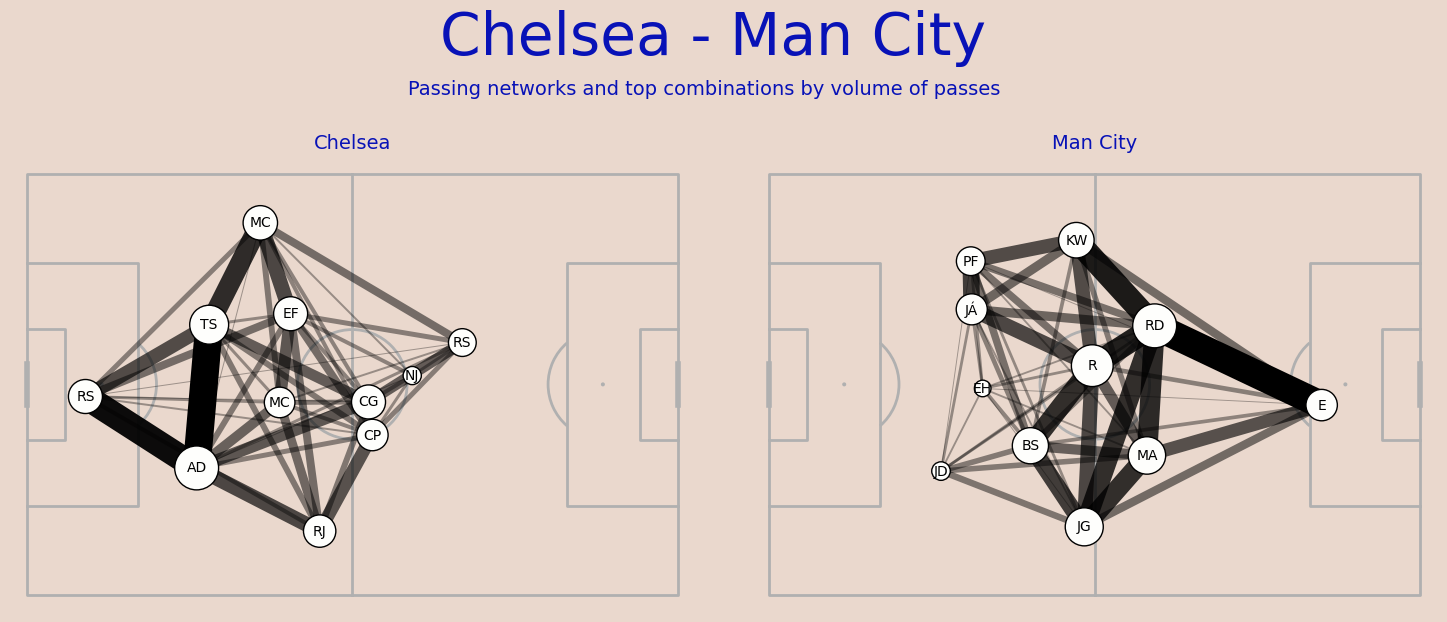

In [54]:
import numpy as np
from matplotlib.colors import to_rgba
# create plot
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
axes = axes.flat
plt.tight_layout()
fig.set_facecolor("#ead8cd")

# plot variables
main_color = '#0812b7'

# home team viz
pass_network_visualization(axes[0], home_passes_between_df, home_average_locs_and_count_df)
axes[0].set_title(teams_dict[home_team_id], color=main_color, fontsize=14)

# away team viz
pass_network_visualization(axes[1], away_passes_between_df, away_average_locs_and_count_df, flipped=True)
axes[1].set_title(teams_dict[away_team_id], color=main_color, fontsize=14)

plt.suptitle(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", color=main_color, fontsize=42)
subtitle = "Passing networks and top combinations by volume of passes"
plt.text(-10, 120, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=14)
#plt.savefig('output.png', bbox_inches='tight')
plt.show()

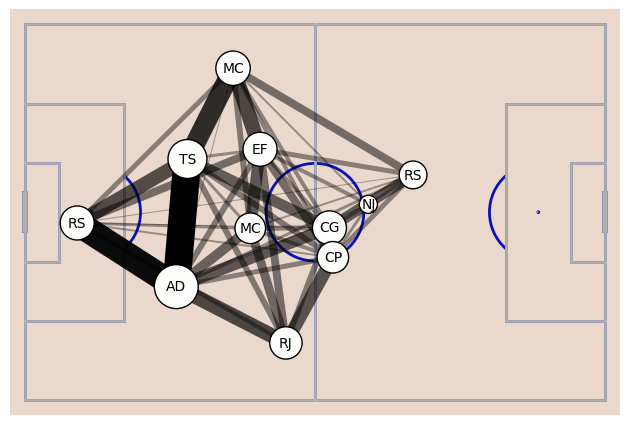

In [55]:
# home team viz
pitch = Pitch(
    pitch_type="opta", pitch_color='#ead8cd', line_color='#0812b7'
)
fig, ax = pitch.draw()
pass_network_visualization(ax,home_passes_between_df, home_average_locs_and_count_df)
#axes[0].set_title(teams_dict[home_team_id], color=main_color, fontsize=14)
plt.show()

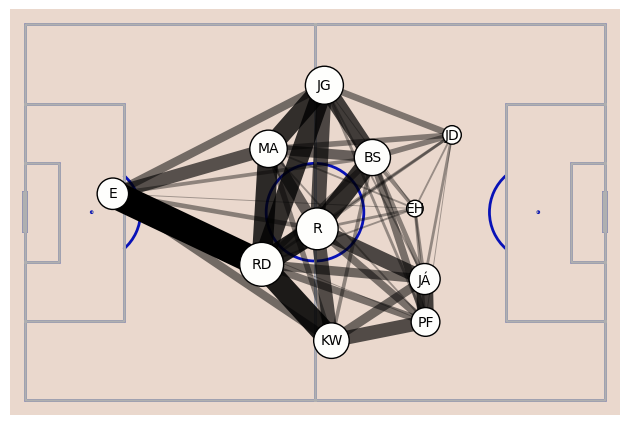

In [56]:
# away team viz
pitch = Pitch(
    pitch_type="opta", pitch_color='#ead8cd', line_color='#0812b7'
)
fig, ax = pitch.draw()
pass_network_visualization(ax, away_passes_between_df, away_average_locs_and_count_df, flipped=True)
plt.show()

In [57]:
def pass_network_visualization2(ax, passes_between_df, average_locs_and_count_df, flipped=False):
    MAX_LINE_WIDTH = 20
    MAX_MARKER_SIZE = 1000
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *
                                  MAX_LINE_WIDTH)
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']
                                                / average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)

    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('#ff4d4d'))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color='#330000')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df['x'] = pitch.dim.right - passes_between_df['x']
        passes_between_df['y'] = pitch.dim.right - passes_between_df['y']
        passes_between_df['x_end'] = pitch.dim.right - passes_between_df['x_end']
        passes_between_df['y_end'] = pitch.dim.right - passes_between_df['y_end']
        average_locs_and_count_df['x'] = pitch.dim.right - average_locs_and_count_df['x']
        average_locs_and_count_df['y'] = pitch.dim.right - average_locs_and_count_df['y']

    pass_lines = pitch.lines(passes_between_df.x, passes_between_df.y,
                             passes_between_df.x_end, passes_between_df.y_end, lw=passes_between_df.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df.x, average_locs_and_count_df.y,
                               s=average_locs_and_count_df.marker_size,
                               color='#FEFEFC', edgecolors='#000000', linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_count_df.iterrows():
        player_name = row["name"].split()
        player_initials = "".join(word[0] for word in player_name).upper()
        pitch.annotate(player_initials, xy=(row.x, row.y), c='#000000', va='center',
                       ha='center', size=10, ax=ax)

    return pitch

https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_pass_network.html

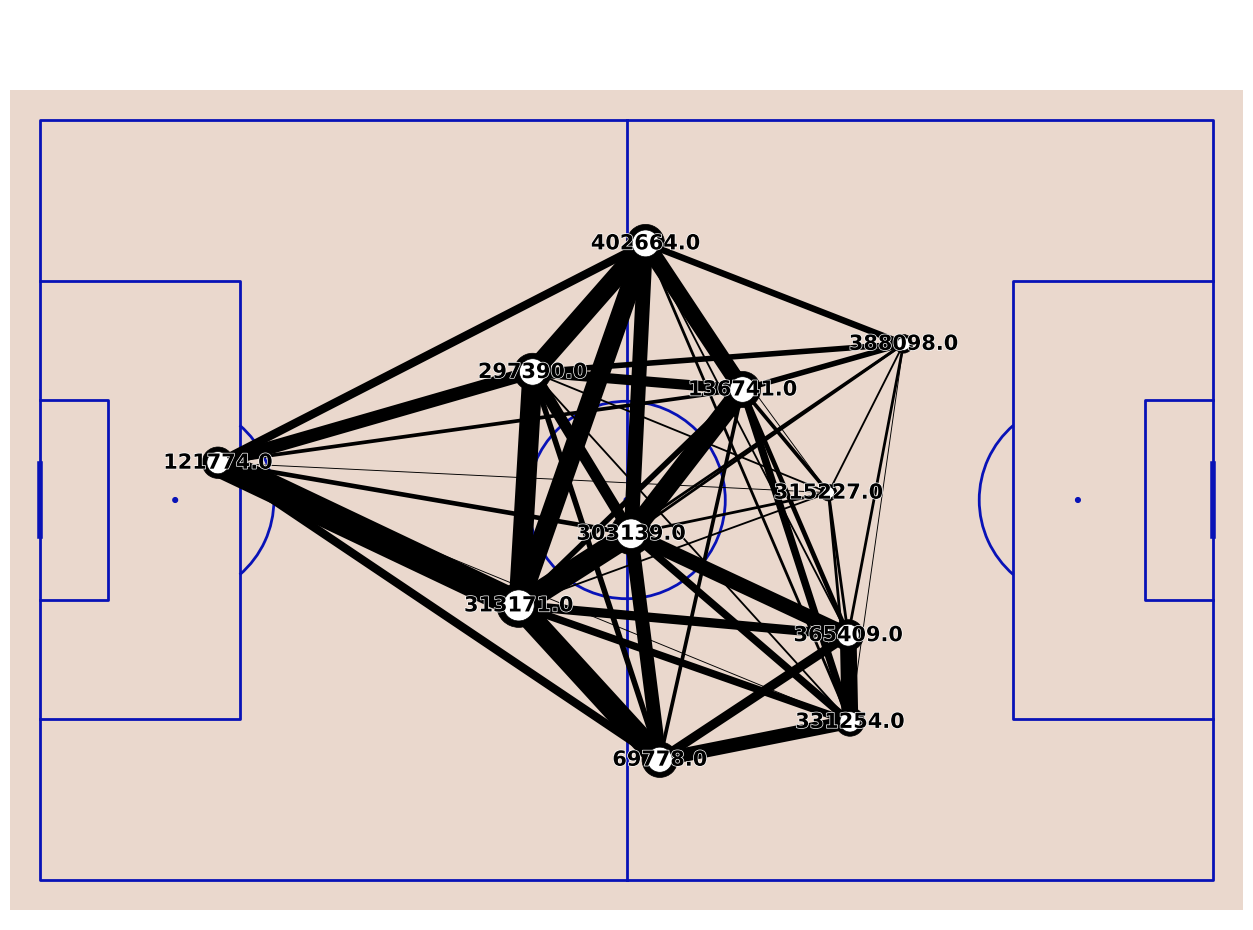

In [58]:
import matplotlib.patheffects as path_effects
pitch = Pitch(
    pitch_type="opta", pitch_color='#ead8cd', line_color='#0812b7'
)
fig, axs = pitch.grid(
    figheight=10,
    title_height=0.08,
    endnote_space=0,
    # Turn off the endnote/title axis. I usually do this after
    # I am happy with the chart layout and text placement
    axis=False,
    title_space=0,
    grid_height=0.82,
    endnote_height=0.01,
)
fig.set_facecolor("white")
pass_lines = pitch.lines(
    away_passes_between_df.x,
   away_passes_between_df.y,
    away_passes_between_df.x_end,
    away_passes_between_df.y_end,
    lw=away_passes_between_df.width,
    color="black",
    zorder=1,
    ax=axs["pitch"],
)
pass_nodes = pitch.scatter(
    away_average_locs_and_count_df.x,
    away_average_locs_and_count_df.y,
    s=away_average_locs_and_count_df.marker_size,
    color="black",
    edgecolors="black",
    linewidth=0.5,
    alpha=1,
    ax=axs["pitch"],
)
pass_nodes_internal = pitch.scatter(
    away_average_locs_and_count_df.x,
    away_average_locs_and_count_df.y,
    s=away_average_locs_and_count_df.marker_size / 2,
    color="white",
    edgecolors="black",
    linewidth=0.5,
    alpha=1,
    ax=axs["pitch"],
)
for index, row in away_average_locs_and_count_df.iterrows():
    text = pitch.annotate(
        row.name,
        xy=(row.x, row.y),
        c="black",
        va="center",
        ha="center",
        size=15,
        weight="bold",
        ax=axs["pitch"],
    )
    text.set_path_effects([path_effects.withStroke(linewidth=1, foreground="white")])

#axs["endnote"].text(
#    1,
#    1,
#    "@your_twitter_handle",
#    color="black",
#    va="center",
#    ha="right",
#    fontsize=15,
#)
#TITLE_TEXT = f"{TEAM}, {FORMATION} formation"
#axs["title"].text(
#    0.5,
#    0.7,
#    TITLE_TEXT,
#    color="black",
#    va="center",
#    ha="center",
#    fontsize=30,
#)
#axs["title"].text(
    #0.5,
    #0.15,
    #OPPONENT,
    #color="black",
#    va="center",
#    ha="center",
#    fontsize=18,
#)

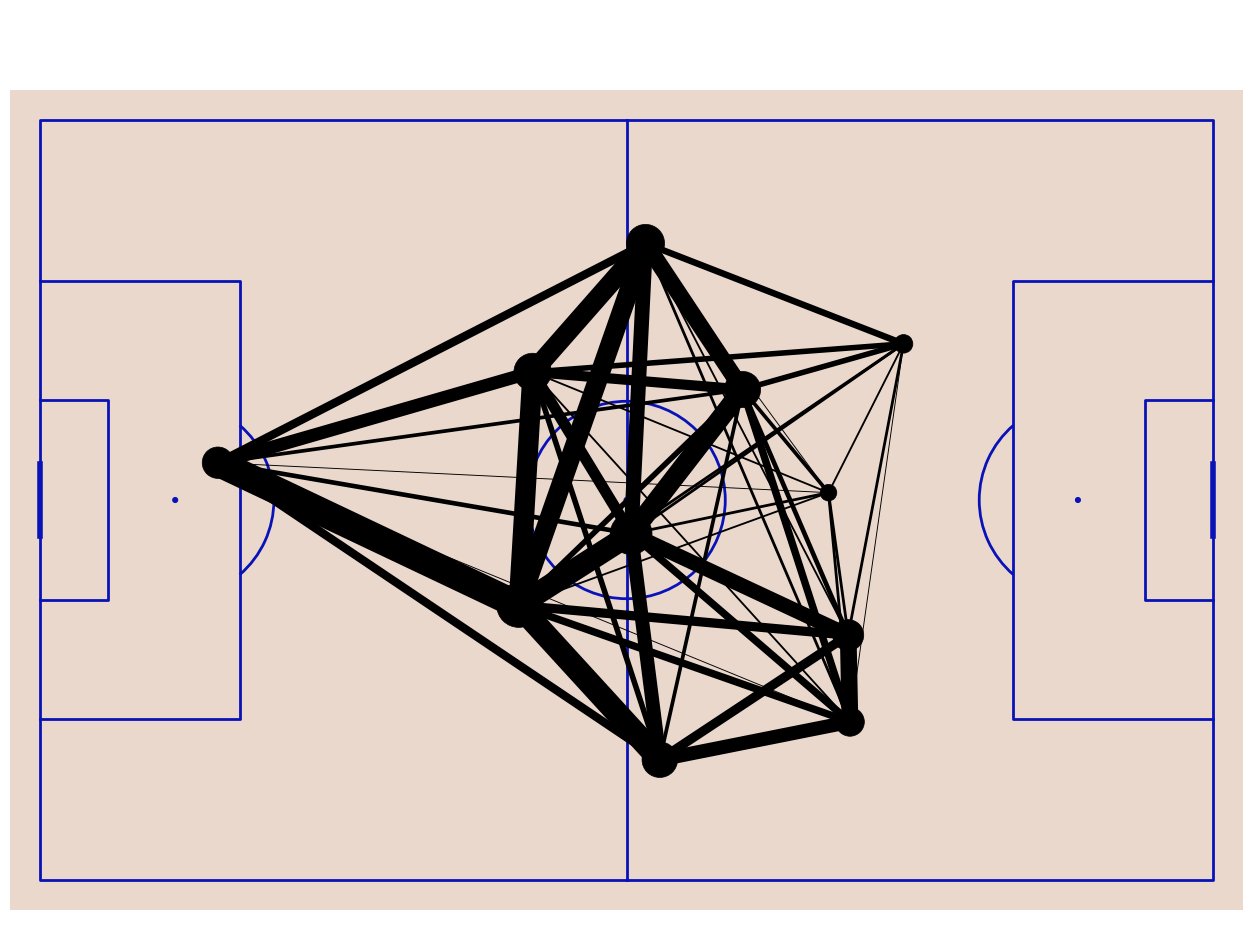

In [59]:
import matplotlib.patheffects as path_effects
pitch = Pitch(
    pitch_type="opta", pitch_color='#ead8cd', line_color='#0812b7'
)
fig, axs = pitch.grid(
    figheight=10,
    title_height=0.08,
    endnote_space=0,
    # Turn off the endnote/title axis. I usually do this after
    # I am happy with the chart layout and text placement
    axis=False,
    title_space=0,
    grid_height=0.82,
    endnote_height=0.01,
)
fig.set_facecolor("white")
pass_lines = pitch.lines(
    away_passes_between_df.x,
   away_passes_between_df.y,
    away_passes_between_df.x_end,
    away_passes_between_df.y_end,
    lw=away_passes_between_df.width,
    color="black",
    zorder=1,
    ax=axs["pitch"],
)
pass_nodes = pitch.scatter(
    away_average_locs_and_count_df.x,
    away_average_locs_and_count_df.y,
    s=away_average_locs_and_count_df.marker_size,
    color="black",
    edgecolors="black",
    linewidth=0.5,
    alpha=1,
    ax=axs["pitch"],
)
pass_nodes_internal = pitch.scatter(
    away_average_locs_and_count_df.x,
    away_average_locs_and_count_df.y,
    s=away_average_locs_and_count_df.marker_size / 2,
    color="black",
    edgecolors="black",
    linewidth=0.5,
    alpha=1,
    ax=axs["pitch"],
)

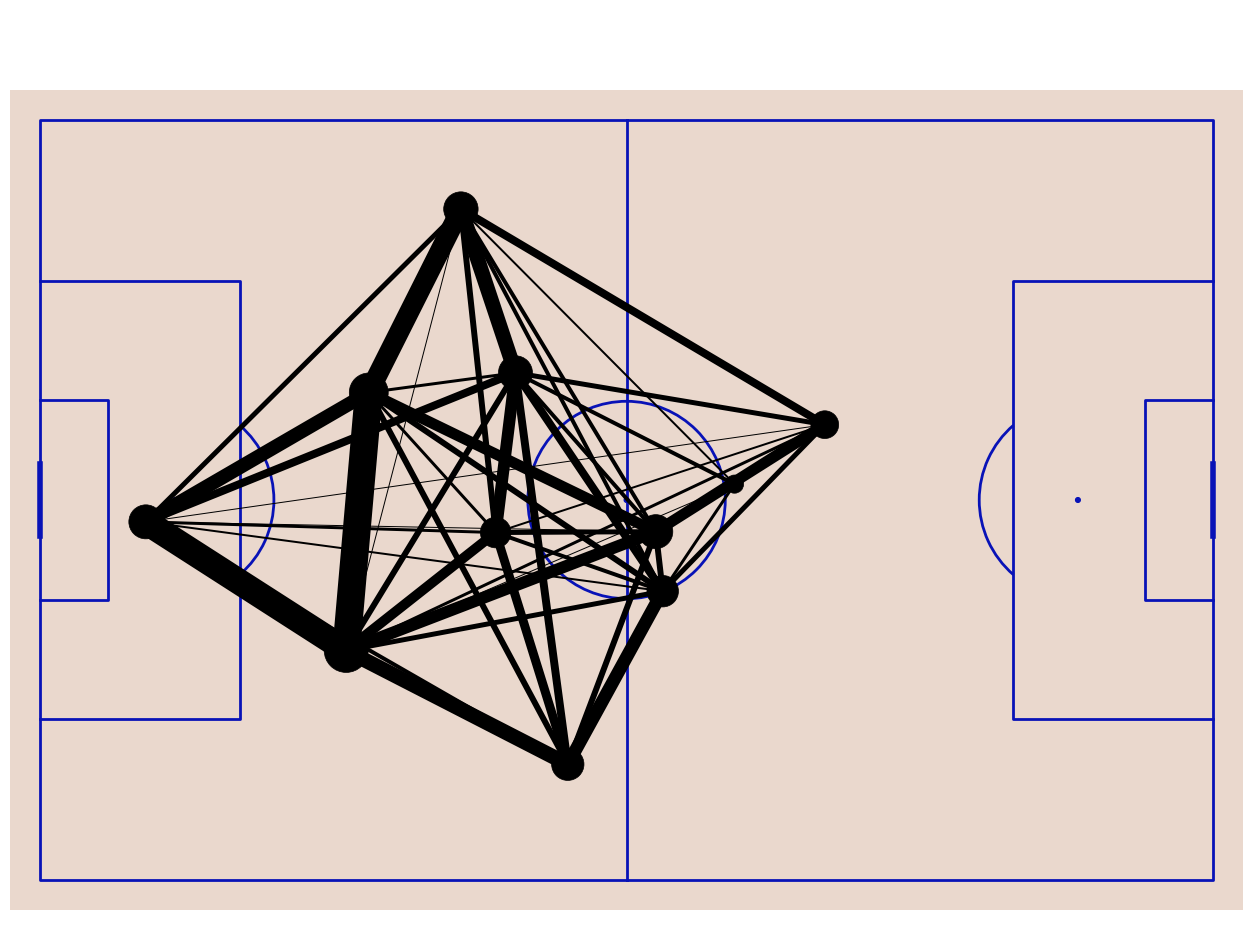

In [60]:
import matplotlib.patheffects as path_effects
pitch = Pitch(
    pitch_type="opta", pitch_color='#ead8cd', line_color='#0812b7'
)
fig, axs = pitch.grid(
    figheight=10,
    title_height=0.08,
    endnote_space=0,
    # Turn off the endnote/title axis. I usually do this after
    # I am happy with the chart layout and text placement
    axis=False,
    title_space=0,
    grid_height=0.82,
    endnote_height=0.01,
)
fig.set_facecolor("white")
pass_lines = pitch.lines(
    home_passes_between_df.x,
    home_passes_between_df.y,
    home_passes_between_df.x_end,
    home_passes_between_df.y_end,
    lw=home_passes_between_df.width,
    color="black",
    zorder=1,
    ax=axs["pitch"],
)
pass_nodes = pitch.scatter(
    home_average_locs_and_count_df.x,
    home_average_locs_and_count_df.y,
    s=home_average_locs_and_count_df.marker_size,
    color="black",
    edgecolors="black",
    linewidth=0.5,
    alpha=1,
    ax=axs["pitch"],
)
pass_nodes_internal = pitch.scatter(
    home_average_locs_and_count_df.x,
    home_average_locs_and_count_df.y,
    s=home_average_locs_and_count_df.marker_size / 2,
    color="black",
    edgecolors="black",
    linewidth=0.5,
    alpha=1,
    ax=axs["pitch"],
)

## Shot maps

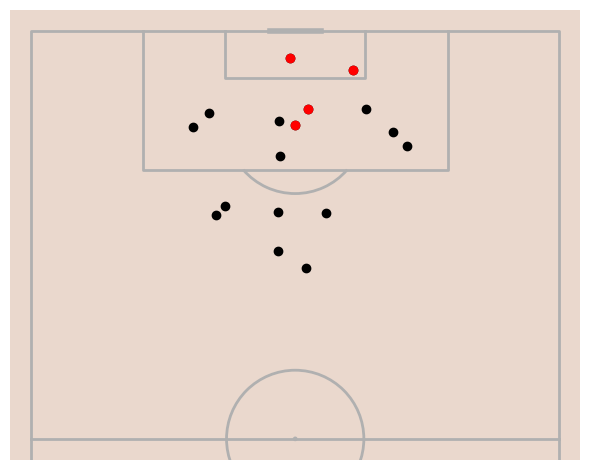

In [61]:
#Chelsea's shots
pitch = VerticalPitch(pitch_type='opta', pitch_color='#ead8cd',half=True)
fig, ax = pitch.draw()
pitch.scatter(home_shots.x,home_shots.y,color='black',ax=ax)
pitch.scatter(home_goals.x,home_goals.y,color='red',ax=ax)

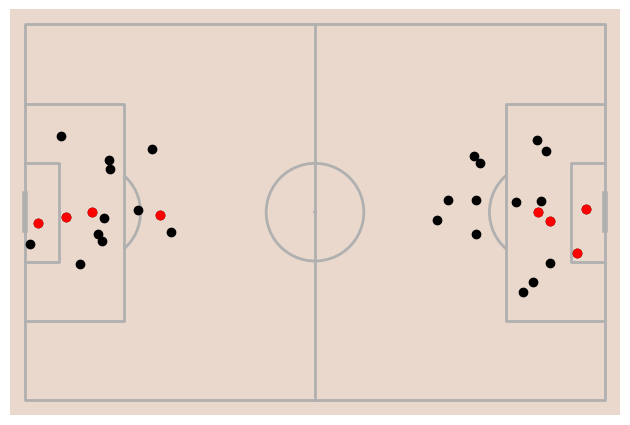

In [62]:
pitch = Pitch(pitch_type='opta', pitch_color='#ead8cd')
fig, ax = pitch.draw()
pitch.scatter(home_shots.x,home_shots.y,color='black',ax=ax)
pitch.scatter(home_goals.x,home_goals.y,color='red',ax=ax)
pitch.scatter(100-away_shots.x,100-away_shots.y,color='black',ax=ax)
pitch.scatter(100-away_goals.x,100-away_goals.y,color='red',ax=ax)

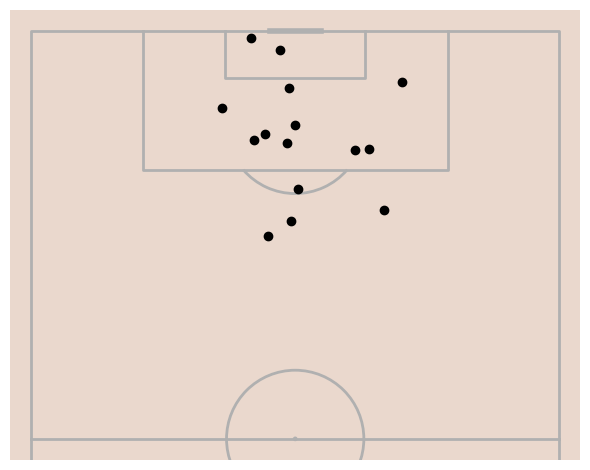

In [63]:
#City's shots
pitch = VerticalPitch(pitch_type='opta', pitch_color='#ead8cd',half=True)
fig, ax = pitch.draw()
pitch.scatter(df_shots[df_shots["teamId"]==167].x,df_shots[df_shots["teamId"]==167].y,color='black',ax=ax)

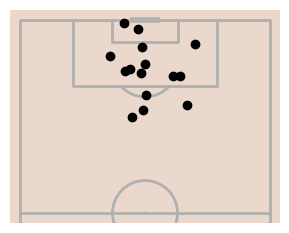

In [64]:
#City's shots
pitch = VerticalPitch(pitch_type='opta', pitch_color='#ead8cd',half=True)
fig, ax = pitch.draw(figsize=(3,3))
pitch.scatter(df_shots[df_shots["teamId"]==167].x,df_shots[df_shots["teamId"]==167].y,color='black',ax=ax)

## Pass maps

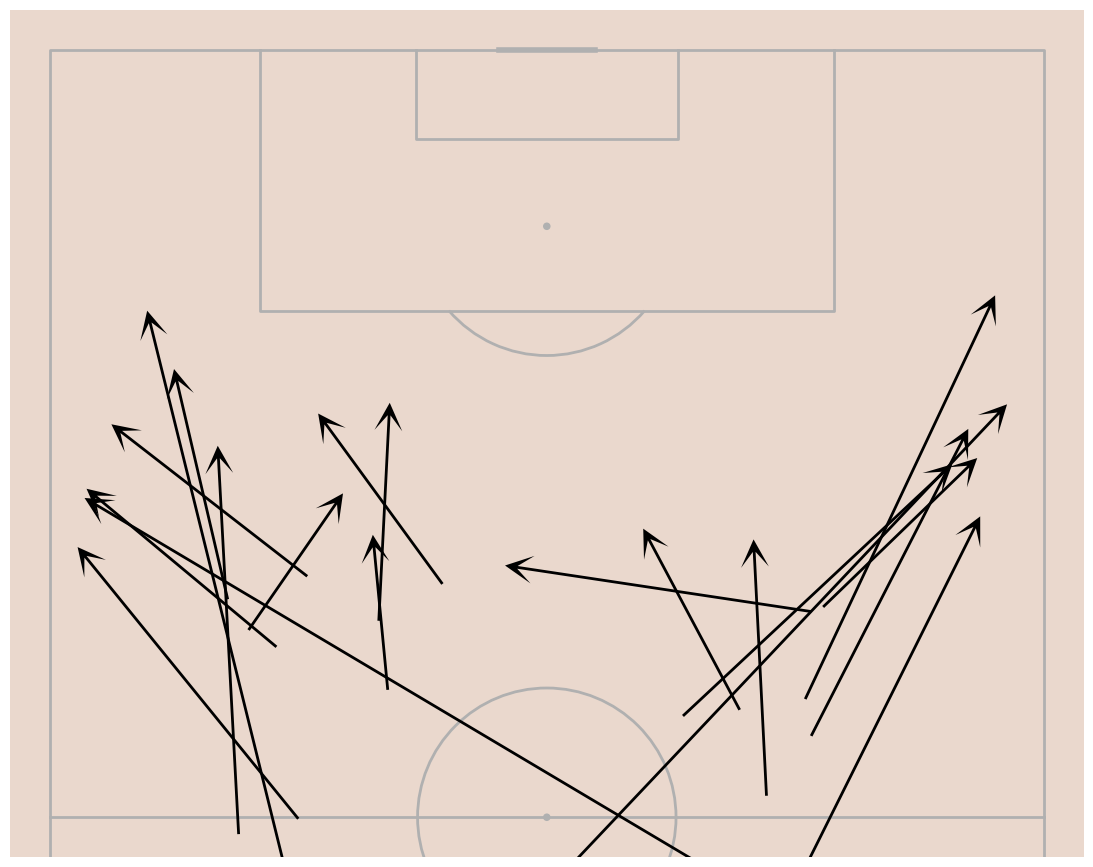

In [65]:
pitch = VerticalPitch(pitch_type='opta', half=True, pitch_color='#ead8cd')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
#fig.set_facecolor('#22312b')
# Plot the completed passes
pitch.arrows(h_comp_final3rd_passes.x, h_comp_final3rd_passes.y,
             h_comp_final3rd_passes.endX, h_comp_final3rd_passes.endY, width=2,
             headwidth=10, headlength=10, color='black', ax=ax, label='completed passes')

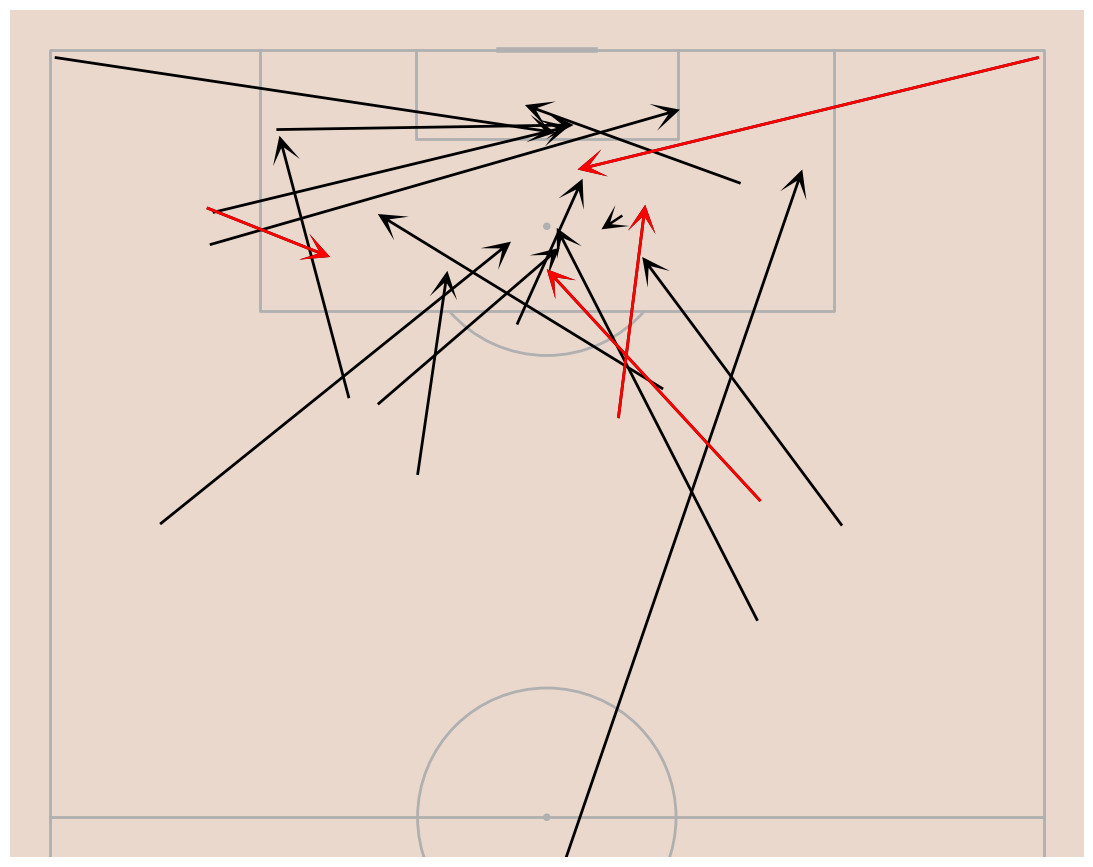

In [66]:
pitch = VerticalPitch(pitch_type='opta', half=True, pitch_color='#ead8cd')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
#fig.set_facecolor('#22312b')
# Plot the completed passes
pitch.arrows(h_passes_intobox.x, h_passes_intobox.y,
             h_passes_intobox.endX, h_passes_intobox.endY, width=2,
             headwidth=10, headlength=10, color='black', ax=ax)
pitch.arrows(h_comp_passes_intobox.x, h_comp_passes_intobox.y,
             h_comp_passes_intobox.endX, h_comp_passes_intobox.endY, width=2,
             headwidth=10, headlength=10, color='red', ax=ax)

## Expected Threat

In [67]:
passes_df

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType,x1_bin,y1_bin,x2_bin,y2_bin,start_zone_value,end_zone_value,xT
2,2.617287e+09,50.4,49.3,44.9,44.5,15,426050.0,369430.0,Pass,Successful,5,3,5,3,0.014846,0.014846,0.000000
3,2.617288e+09,47.5,44.0,60.8,3.2,15,369430.0,361330.0,Pass,Successful,5,3,7,0,0.014846,0.017451,0.002605
4,2.617288e+09,43.6,10.7,26.7,29.4,15,361330.0,300426.0,Pass,Successful,5,0,3,2,0.012483,0.011105,-0.001379
5,2.617288e+09,26.7,29.4,8.7,49.7,15,300426.0,362151.0,Pass,Successful,3,2,0,3,0.011105,0.009411,-0.001694
6,2.617288e+09,9.9,55.7,41.9,91.1,15,362151.0,97692.0,Pass,Successful,0,4,4,7,0.009411,0.011263,0.001852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,2.617414e+09,41.0,82.1,59.6,93.8,15,363496.0,409376.0,Pass,Successful,4,6,7,7,0.012147,0.017451,0.005303
1580,2.617414e+09,44.6,25.3,45.5,54.5,167,136741.0,97692.0,Pass,Unsuccessful,5,2,5,4,0.014291,0.014846,0.000555
1586,2.617414e+09,30.3,48.5,35.2,37.1,167,303139.0,136741.0,Pass,Successful,3,3,4,2,0.011324,0.012692,0.001368
1587,2.617414e+09,35.1,38.6,36.9,62.1,167,136741.0,93894.0,Pass,Successful,4,3,4,4,0.012626,0.012626,0.000000


In [68]:
players_ids

{'393407': 'Armando Broja',
 '369430': 'Enzo Fernández',
 '28550': 'Thiago Silva',
 '410175': 'Moisés Caicedo',
 '404616': 'Lesley Ugochukwu',
 '300426': 'Axel Disasi',
 '403850': 'Malo Gusto',
 '365406': 'Benoît Badiashile',
 '384134': 'Ian Maatsen',
 '426050': 'Nicolas Jackson',
 '406564': 'Djordje Petrovic',
 '362151': 'Robert Sánchez',
 '363496': 'Marc Cucurella',
 '409376': 'Mykhailo Mudryk',
 '502567': 'Alex Matos',
 '361330': 'Reece James',
 '97692': 'Raheem Sterling',
 '375621': 'Conor Gallagher',
 '395692': 'Cole Palmer',
 '389935': 'Noni Madueke',
 '365409': 'Julián Álvarez',
 '388098': 'Jérémy Doku',
 '121774': 'Ederson',
 '402664': 'Josko Gvardiol',
 '93894': 'Mateo Kovacic',
 '133569': 'Stefan Ortega',
 '430709': 'Oscar Bobb',
 '315227': 'Erling Haaland',
 '136741': 'Bernardo Silva',
 '394933': 'Matheus Nunes',
 '313171': 'Rúben Dias',
 '303139': 'Rodri',
 '297390': 'Manuel Akanji',
 '69778': 'Kyle Walker',
 '8155': 'Scott Carson',
 '444791': 'Rico Lewis',
 '331254': 'Phil

In [69]:
#Nicolas Jackson's passing dataframe
nj_xT = passes_df[passes_df['playerId']==426050]
nj_xT

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType,x1_bin,y1_bin,x2_bin,y2_bin,start_zone_value,end_zone_value,xT
2,2.617287e+09,50.4,49.3,44.9,44.5,15,426050.0,369430.0,Pass,Successful,5,3,5,3,0.014846,0.014846,0.000000
10,2.617288e+09,77.7,63.1,76.3,39.7,15,426050.0,395692.0,Pass,Successful,9,5,9,3,0.028552,0.035113,0.006561
37,2.617289e+09,53.1,60.2,68.0,65.1,15,426050.0,69778.0,Pass,Unsuccessful,6,4,8,5,0.016895,0.024122,0.007227
94,2.617293e+09,55.5,30.4,62.8,39.2,15,426050.0,297390.0,Pass,Unsuccessful,6,2,7,3,0.016856,0.019971,0.003115
119,2.617294e+09,89.2,42.4,88.3,44.5,15,426050.0,313171.0,Pass,Unsuccessful,10,3,10,3,0.108051,0.108051,0.000000
388,2.617319e+09,50.0,49.9,44.3,51.8,15,426050.0,369430.0,Pass,Successful,5,3,5,4,0.014846,0.014846,0.000000
609,2.617337e+09,77.2,72.3,81.7,70.0,15,426050.0,313171.0,Pass,Unsuccessful,9,5,9,5,0.028552,0.028552,0.000000
680,2.617343e+09,50.0,49.9,43.0,52.4,15,426050.0,369430.0,Pass,Successful,5,3,5,4,0.014846,0.014846,0.000000
1135,2.617389e+09,53.1,36.0,39.4,31.6,15,426050.0,303139.0,Pass,Unsuccessful,6,2,4,2,0.016856,0.012692,-0.004164
1335,2.617399e+09,68.9,40.3,73.5,55.7,15,426050.0,395692.0,Pass,Successful,8,3,8,4,0.023851,0.023851,0.000000


In [70]:
#Nicolas Jackson's passing xT
nj_xT.xT.sum()

0.01543767

In [71]:
passes_df['playerId'] = passes_df['playerId'].astype('string').str.split('.').str[0]
passes_df['playerId'] = passes_df['playerId'].map(players_ids)
passes_df

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType,x1_bin,y1_bin,x2_bin,y2_bin,start_zone_value,end_zone_value,xT
2,2.617287e+09,50.4,49.3,44.9,44.5,15,Nicolas Jackson,369430.0,Pass,Successful,5,3,5,3,0.014846,0.014846,0.000000
3,2.617288e+09,47.5,44.0,60.8,3.2,15,Enzo Fernández,361330.0,Pass,Successful,5,3,7,0,0.014846,0.017451,0.002605
4,2.617288e+09,43.6,10.7,26.7,29.4,15,Reece James,300426.0,Pass,Successful,5,0,3,2,0.012483,0.011105,-0.001379
5,2.617288e+09,26.7,29.4,8.7,49.7,15,Axel Disasi,362151.0,Pass,Successful,3,2,0,3,0.011105,0.009411,-0.001694
6,2.617288e+09,9.9,55.7,41.9,91.1,15,Robert Sánchez,97692.0,Pass,Successful,0,4,4,7,0.009411,0.011263,0.001852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,2.617414e+09,41.0,82.1,59.6,93.8,15,Marc Cucurella,409376.0,Pass,Successful,4,6,7,7,0.012147,0.017451,0.005303
1580,2.617414e+09,44.6,25.3,45.5,54.5,167,Bernardo Silva,97692.0,Pass,Unsuccessful,5,2,5,4,0.014291,0.014846,0.000555
1586,2.617414e+09,30.3,48.5,35.2,37.1,167,Rodri,136741.0,Pass,Successful,3,3,4,2,0.011324,0.012692,0.001368
1587,2.617414e+09,35.1,38.6,36.9,62.1,167,Bernardo Silva,93894.0,Pass,Successful,4,3,4,4,0.012626,0.012626,0.000000


In [72]:
players = passes_df["playerId"].unique()
players

array(['Nicolas Jackson', 'Enzo Fernández', 'Reece James', 'Axel Disasi',
       'Robert Sánchez', 'Conor Gallagher', 'Thiago Silva', 'Cole Palmer',
       'Marc Cucurella', 'Moisés Caicedo', 'Kyle Walker', 'Ederson',
       'Rúben Dias', 'Josko Gvardiol', 'Bernardo Silva', 'Manuel Akanji',
       'Jérémy Doku', 'Julián Álvarez', 'Raheem Sterling', 'Rodri',
       'Phil Foden', 'Erling Haaland', 'Jack Grealish', 'Mykhailo Mudryk',
       'Malo Gusto', 'Mateo Kovacic'], dtype=object)

In [73]:
passes_df

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType,x1_bin,y1_bin,x2_bin,y2_bin,start_zone_value,end_zone_value,xT
2,2.617287e+09,50.4,49.3,44.9,44.5,15,Nicolas Jackson,369430.0,Pass,Successful,5,3,5,3,0.014846,0.014846,0.000000
3,2.617288e+09,47.5,44.0,60.8,3.2,15,Enzo Fernández,361330.0,Pass,Successful,5,3,7,0,0.014846,0.017451,0.002605
4,2.617288e+09,43.6,10.7,26.7,29.4,15,Reece James,300426.0,Pass,Successful,5,0,3,2,0.012483,0.011105,-0.001379
5,2.617288e+09,26.7,29.4,8.7,49.7,15,Axel Disasi,362151.0,Pass,Successful,3,2,0,3,0.011105,0.009411,-0.001694
6,2.617288e+09,9.9,55.7,41.9,91.1,15,Robert Sánchez,97692.0,Pass,Successful,0,4,4,7,0.009411,0.011263,0.001852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,2.617414e+09,41.0,82.1,59.6,93.8,15,Marc Cucurella,409376.0,Pass,Successful,4,6,7,7,0.012147,0.017451,0.005303
1580,2.617414e+09,44.6,25.3,45.5,54.5,167,Bernardo Silva,97692.0,Pass,Unsuccessful,5,2,5,4,0.014291,0.014846,0.000555
1586,2.617414e+09,30.3,48.5,35.2,37.1,167,Rodri,136741.0,Pass,Successful,3,3,4,2,0.011324,0.012692,0.001368
1587,2.617414e+09,35.1,38.6,36.9,62.1,167,Bernardo Silva,93894.0,Pass,Successful,4,3,4,4,0.012626,0.012626,0.000000


In [74]:
passes_df[passes_df['playerId']=='Nicolas Jackson'].xT.sum()

0.01543767

*Note on the following: I know there has to be a better way but for now I haven't figured it out...*

In [75]:
xT_df = passes_df[['teamId','playerId','xT']].copy()

In [76]:
xT_df

,teamId,playerId,xT
2,15,Nicolas Jackson,0.000000
3,15,Enzo Fernández,0.002605
4,15,Reece James,-0.001379
5,15,Axel Disasi,-0.001694
6,15,Robert Sánchez,0.001852
...,...,...,...
1576,15,Marc Cucurella,0.005303
1580,167,Bernardo Silva,0.000555
1586,167,Rodri,0.001368
1587,167,Bernardo Silva,0.000000


In [77]:
xT_df2 = xT_df.copy()

In [78]:
xT_ranking = pd.DataFrame(xT_df2.groupby(['teamId','playerId'])['xT'].sum())
xT_ranking = xT_ranking.sort_values('xT',ascending=False)
xT_ranking

xT
teamId playerId                 
15     Raheem Sterling  0.832807
167    Bernardo Silva   0.776628
       Julián Álvarez   0.674459
15     Cole Palmer      0.449203
167    Jérémy Doku      0.357349
15     Conor Gallagher  0.334997
167    Rúben Dias       0.301137
       Phil Foden       0.298151
15     Reece James      0.276602
167    Rodri            0.192890
15     Enzo Fernández   0.151288
167    Erling Haaland   0.127836
       Manuel Akanji    0.103058
       Mateo Kovacic    0.092373
       Ederson          0.084776
       Jack Grealish    0.081453
15     Robert Sánchez   0.080280
       Thiago Silva     0.079315
167    Josko Gvardiol   0.059222
       Kyle Walker      0.058759
15     Axel Disasi      0.058560
       Marc Cucurella   0.056852
       Nicolas Jackson  0.015438
       Mykhailo Mudryk  0.002901
       Moisés Caicedo  -0.005387
       Malo Gusto      -0.016237

In [79]:
csv_data = xT_ranking.to_csv('xT_ranking.csv', index = True) 

In [80]:
xT = pd.read_csv('xT_ranking.csv')

In [81]:
xT

,teamId,playerId,xT
0,15,Raheem Sterling,0.832807
1,167,Bernardo Silva,0.776628
2,167,Julián Álvarez,0.674459
3,15,Cole Palmer,0.449203
4,167,Jérémy Doku,0.357349
5,15,Conor Gallagher,0.334997
6,167,Rúben Dias,0.301137
7,167,Phil Foden,0.298151
8,15,Reece James,0.276602
9,167,Rodri,0.192890


In [82]:
xT = xT.sort_values(by=['xT'])
xT

,teamId,playerId,xT
25,15,Malo Gusto,-0.016237
24,15,Moisés Caicedo,-0.005387
23,15,Mykhailo Mudryk,0.002901
22,15,Nicolas Jackson,0.015438
21,15,Marc Cucurella,0.056852
20,15,Axel Disasi,0.058560
19,167,Kyle Walker,0.058759
18,167,Josko Gvardiol,0.059222
17,15,Thiago Silva,0.079315
16,15,Robert Sánchez,0.080280


In [83]:
xT2 = xT.copy()

In [84]:
xT2 = xT2.replace(to_replace=15,value="Chelsea")
xT2 = xT2.replace(to_replace=167,value="Manchester City")
xT2 = xT2.sort_values("xT",ascending=False)
xT2 = xT2[0:11]
xT2 = xT2.sort_values("xT",ascending=True)
xT2

,teamId,playerId,xT
10,Chelsea,Enzo Fernández,0.151288
9,Manchester City,Rodri,0.192890
8,Chelsea,Reece James,0.276602
7,Manchester City,Phil Foden,0.298151
6,Manchester City,Rúben Dias,0.301137
5,Chelsea,Conor Gallagher,0.334997
4,Manchester City,Jérémy Doku,0.357349
3,Chelsea,Cole Palmer,0.449203
2,Manchester City,Julián Álvarez,0.674459
1,Manchester City,Bernardo Silva,0.776628


In [85]:
#xT2[xT2["xT"]>=.05]

In [86]:
#xT2[0:15]

<BarContainer object of 11 artists>

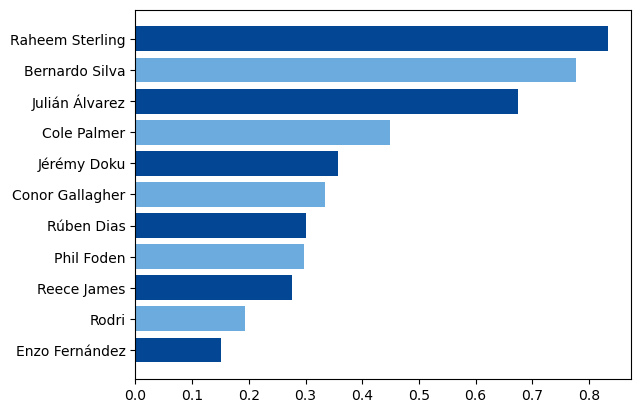

In [87]:
palette = ['#034694', '#6CABDD']
ax.set_facecolor("yellow")
plt.barh(data=xT2, y='playerId',width="xT",color=palette)

## Team tables

In [88]:
from tabulate import tabulate

In [89]:
h_stats = [["Possession(%)", h_poss], 
        ["Field Tilt(%)", h_field_tilt], 
        ["PPDA", h_PPDA]]

In [90]:
print(tabulate(h_stats))

-------------  ----
Possession(%)  45.2
Field Tilt(%)  35.6
PPDA            7.6
-------------  ----


Text(1.5, 4, 'GOALS\nSCORED')

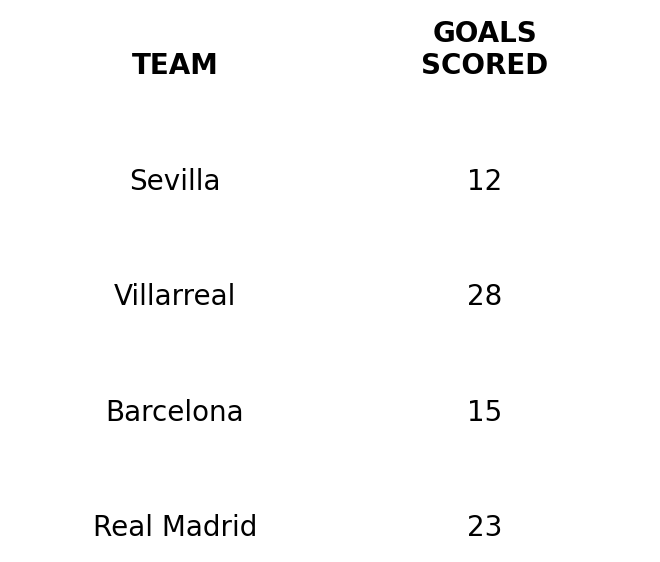

In [91]:
# This is random data.
data = {
    'teams': ['Real Madrid', 'Barcelona', 'Villarreal', 'Sevilla'],
    'goals_scored': [23, 15, 28, 12]
}
fig = plt.figure(figsize=(4,3), dpi=200)
ax = plt.subplot(111)

ncols = 2
nrows = 4

ax.set_xlim(0, ncols)
ax.set_ylim(0, nrows)
ax.set_axis_off()

for y in range(0, nrows):
    ax.annotate(
        xy=(0.5,y),
        text=data['teams'][y],
        ha='center'
    )
    ax.annotate(
        xy=(1.5,y),
        text=data['goals_scored'][y],
        ha='center'
    )

ax.annotate(
    xy=(0.5, nrows),
    text='TEAM',
    weight='bold',
    ha='center'
)
ax.annotate(
    xy=(1.5, nrows),
    text='GOALS\nSCORED',
    weight='bold',
    ha='center'
)

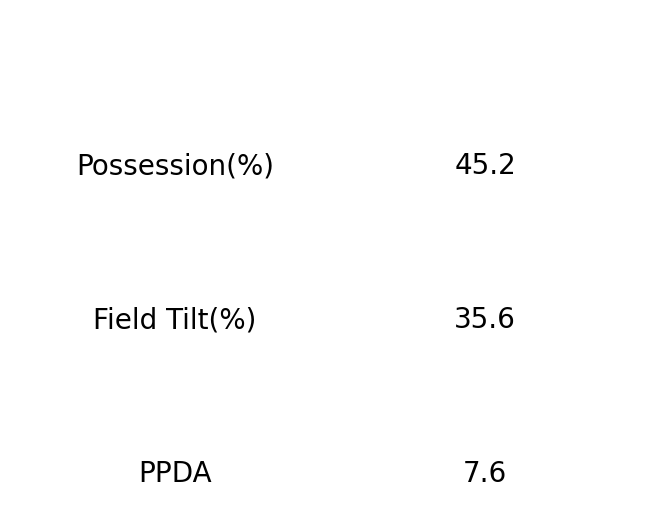

In [92]:
# This is random data.
data = {
    'Metric': ['PPDA','Field Tilt(%)','Possession(%)'],
    'Chelsea': [h_PPDA, h_field_tilt, h_poss]
}
fig = plt.figure(figsize=(4,3), dpi=200)
ax = plt.subplot(111)

ncols = 2
nrows = 3

ax.set_xlim(0, ncols)
ax.set_ylim(0, nrows)
ax.set_axis_off()

for y in range(0, nrows):
    ax.annotate(
        xy=(0.5,y),
        text=data['Metric'][y],
        ha='center'
    )
    ax.annotate(
        xy=(1.5,y),
        text=data['Chelsea'][y],
        ha='center'
    )

# Putting it all together in a Dashboard

***Dark theme***

Text(0.98, 0.1, 'Data via Opta')

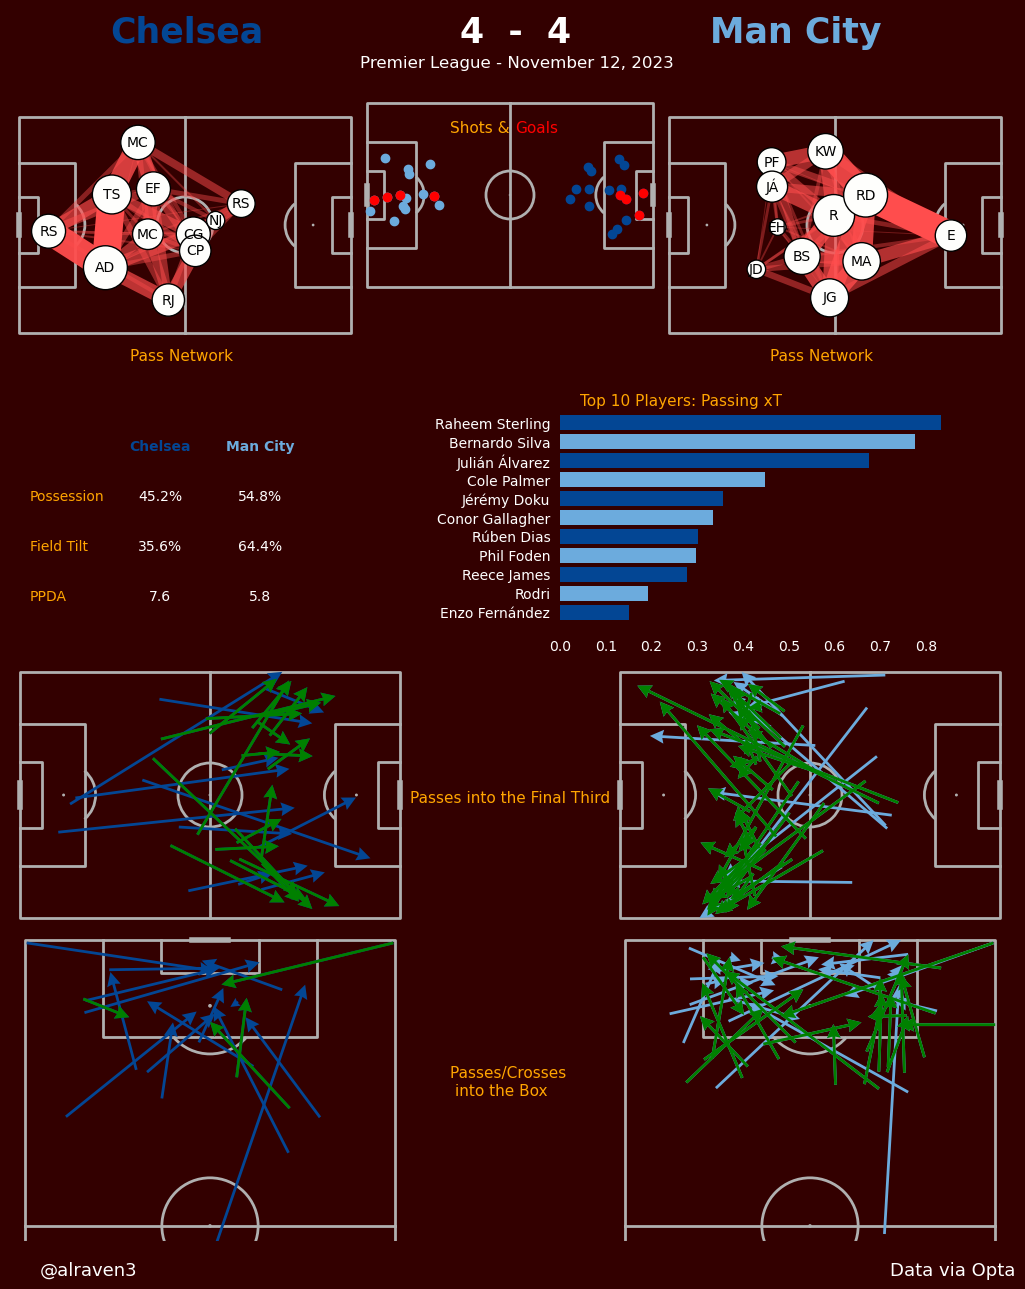

In [142]:
from highlight_text import HighlightText, ax_text, fig_text

background = '#330000'
text_color = 'white'
h_color = '#034694'
a_color = '#6CABDD'
plot_title_color = 'orange'

# SETTING UP THE AXES
fig, ax = plt.subplots(figsize=(10,15))
ax.axis('off')
fig.set_facecolor(background)
pitch = mplsoccer.VerticalPitch(half=True,pitch_type='opta',pitch_color=background)
pitch2 = mplsoccer.Pitch(pitch_type='opta',pitch_color=background)

ax1 = fig.add_axes((0.1, 0.65, 0.35, 0.3))
pass_network_visualization2(ax1,home_passes_between_df, home_average_locs_and_count_df)

ax2 = fig.add_axes((0.75, 0.65, 0.35, 0.3))
pass_network_visualization2(ax2, away_passes_between_df, away_average_locs_and_count_df, flipped=True)


ax3 = fig.add_axes((0.45, 0.62, 0.3, 0.4))
pitch2.draw(ax=ax3)
pitch2.scatter(home_shots.x,home_shots.y,color=h_color,ax=ax3)
pitch2.scatter(home_goals.x,home_goals.y,color='red',ax=ax3)
pitch2.scatter(pitch2.dim.right-away_shots.x,pitch2.dim.right-away_shots.y,color=a_color,ax=ax3)
pitch2.scatter(pitch2.dim.right-away_goals.x,pitch2.dim.right-away_goals.y,color='red',ax=ax3)

ax4 = fig.add_axes((0.1, 0.55, 0.3, 0.1))
ax4.set_facecolor(background)
match_stats = {
    'Metric': ['PPDA','Field Tilt','Possession'],
    'Chelsea' : [h_PPDA, str(h_field_tilt)+"%", str(h_poss)+"%"],
    'Man City' : [a_PPDA, str(a_field_tilt)+"%", str(a_poss)+"%"]
}
ncols = 3
nrows = 3
ax4.set_xlim(0, ncols)
ax4.set_ylim(0, nrows)
ax4.set_axis_off()
for y in range(0, nrows):
    ax4.annotate(
        xy=(0.2,y),
        text=match_stats['Metric'][y],
        ha='left',
        color=plot_title_color
    )
    ax4.annotate(
        xy=(1.5,y),
        text=match_stats['Chelsea'][y],
        ha='center',
        color=text_color
    )
    ax4.annotate(
        xy=(2.5,y),
        text=match_stats['Man City'][y],
        ha='center',
        color=text_color
    )
ax4.annotate(
    xy=(1.5, nrows),
    text='Chelsea',
    weight='bold',
    ha='center',
    color=h_color
)
ax4.annotate(
    xy=(2.5, nrows),
    text='Man City',
    weight='bold',
    ha='center',
    color=a_color
)

ax5 = fig.add_axes((0.65, 0.53, 0.4, 0.15))
ax5.set_facecolor(background)
ax5.tick_params(top=False, labeltop=False, bottom=False, labelbottom=True,colors=text_color)
ax5.tick_params(axis='y',left=False, colors=text_color) 
ax5.spines[['right', 'top','left','bottom']].set_visible(False)
palette = [h_color, a_color]
plt.barh(data=xT2, y='playerId',width="xT",color=palette)

ax6 = fig.add_axes((0.1, 0.22, 0.4, 0.4))
pitch2.draw(ax=ax6)
pitch2.arrows(h_final_3rd_passes.x, h_final_3rd_passes.y,
             h_final_3rd_passes.endX, h_final_3rd_passes.endY, width=2,
             headwidth=5, headlength=5, color=h_color, ax=ax6)
pitch2.arrows(h_comp_final3rd_passes.x, h_comp_final3rd_passes.y,
             h_comp_final3rd_passes.endX, h_comp_final3rd_passes.endY, width=2,
             headwidth=5, headlength=5, color='green', ax=ax6)

ax7 = fig.add_axes((0.7, 0.22, 0.4, 0.4))
pitch2.draw(ax=ax7)
pitch2.arrows(100-a_final_3rd_passes.x, 100-a_final_3rd_passes.y,
             100-a_final_3rd_passes.endX, 100-a_final_3rd_passes.endY, width=2,
             headwidth=5, headlength=5, color=a_color, ax=ax7)
pitch2.arrows(100-a_comp_final3rd_passes.x, 100-a_comp_final3rd_passes.y,
             100-a_comp_final3rd_passes.endX, 100-a_comp_final3rd_passes.endY, width=2,
             headwidth=5, headlength=5, color='green', ax=ax7)

ax8 = fig.add_axes((0.1, 0.028, 0.4, 0.4))
pitch.draw(ax=ax8)
pitch.arrows(h_passes_intobox.x, h_passes_intobox.y,
             h_passes_intobox.endX, h_passes_intobox.endY, width=2,
             headwidth=5, headlength=5, color=h_color, ax=ax8)
pitch.arrows(h_comp_passes_intobox.x, h_comp_passes_intobox.y,
             h_comp_passes_intobox.endX, h_comp_passes_intobox.endY, width=2,
             headwidth=5, headlength=5, color='green', ax=ax8)

ax9 = fig.add_axes((0.7, 0.028, 0.4, 0.4))
pitch.draw(ax=ax9)
pitch.arrows(a_passes_intobox.x, a_passes_intobox.y,
             a_passes_intobox.endX, a_passes_intobox.endY, width=2,
             headwidth=5, headlength=5, color=a_color, ax=ax9)
pitch.arrows(a_comp_passes_intobox.x, a_comp_passes_intobox.y,
             a_comp_passes_intobox.endX, a_comp_passes_intobox.endY, width=2,
             headwidth=5, headlength=5, color='green', ax=ax9)

# ADDING TITLES AND INFO
fig_text(0.2,0.94,"<Chelsea>",weight='heavy', size=25,highlight_textprops=[{'color':h_color}])
fig_text(0.55,0.94,"4  -  4",weight='heavy', color=text_color,size=25)
fig_text(0.8,0.94,"<Man City>",weight='heavy', size=25, highlight_textprops=[{"color": a_color}])
fig.text(0.45,0.905,"Premier League - November 12, 2023", color=text_color,size=12)
fig_text(0.54,0.87,'Shots &', color=plot_title_color, size=11)
fig_text(0.605,0.87,'Goals', color="red", size=11)
fig.text(0.22,0.71,'Pass Network', color=plot_title_color, size=11)
fig.text(0.86,0.71,'Pass Network', color=plot_title_color, size=11)
#fig.text(0.2,0.745,'Pass Network', color=plot_title_color, size=11)
#fig.text(0.9,0.745,'Pass Network', color=plot_title_color, size=11)
fig.text(0.67,0.68,'Top 10 Players: Passing xT', color=plot_title_color, size=11)
fig.text(0.5,0.415,'Passes into the Final Third', color=plot_title_color, size=11)
fig.text(0.54,0.22,'Passes/Crosses \n into the Box', color=plot_title_color, size=11)
fig.text(0.13,0.1,'@alraven3', color=text_color, size=13)
fig.text(0.98,0.1,'Data via Opta', color=text_color, size=13)

#plt.savefig("AR Dashboard 02 DARK.png")

***Light/beige theme***

Text(0.98, 0.1, 'Data via Opta')

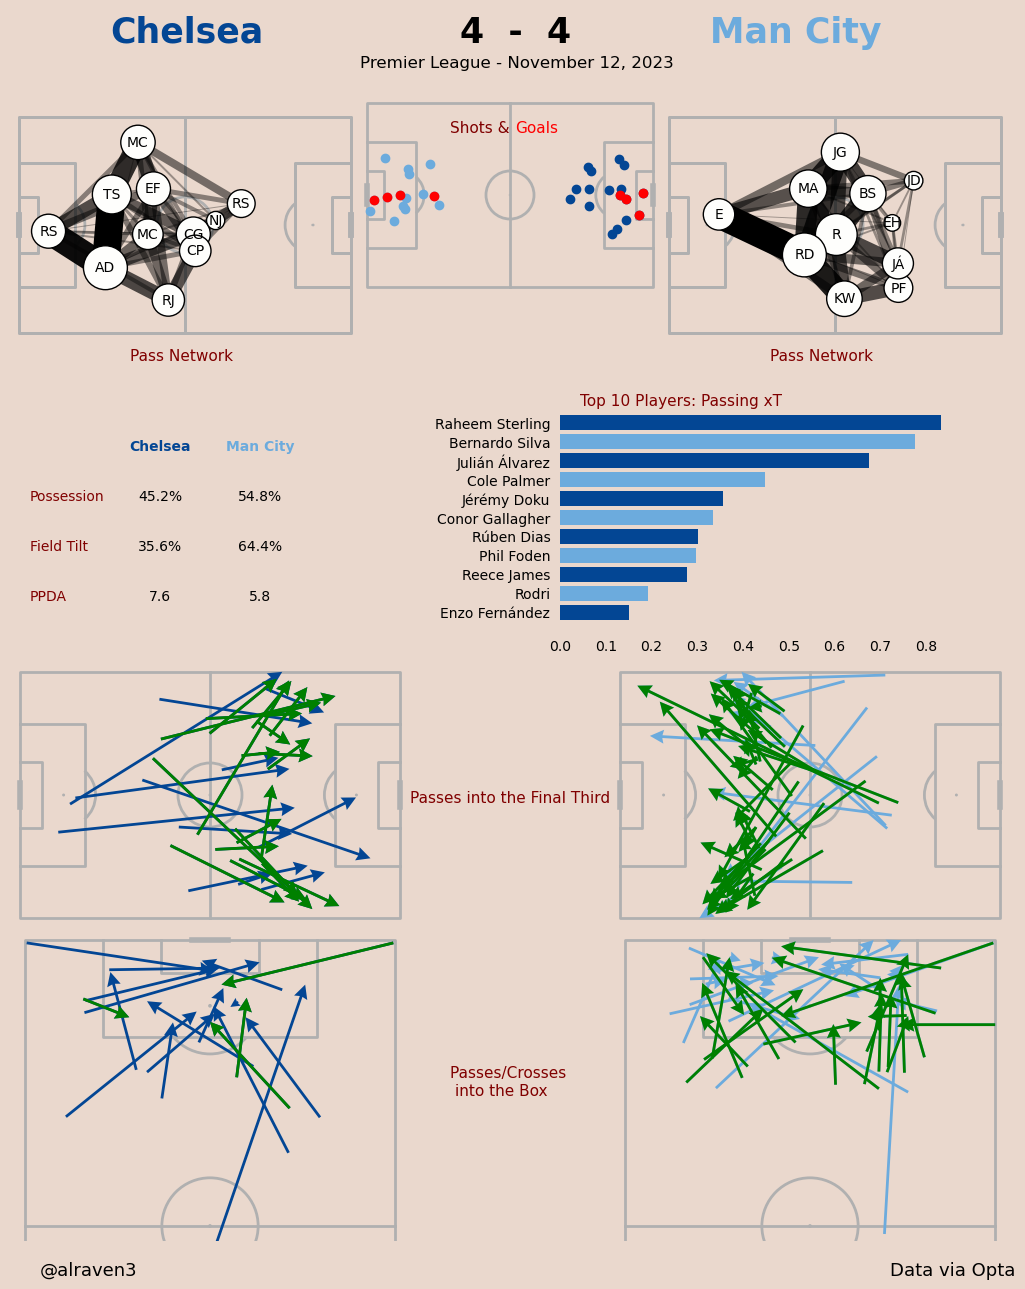

In [143]:
from highlight_text import HighlightText, fig_text

background = '#ead8cd'
text_color = 'black'
h_color = '#034694'
a_color = '#6CABDD'
plot_title_color = 'maroon'

# SETTING UP THE AXES
fig, ax = plt.subplots(figsize=(10,15))
ax.axis('off')
fig.set_facecolor(background)
pitch = mplsoccer.VerticalPitch(half=True,pitch_type='opta',pitch_color=background)
pitch2 = mplsoccer.Pitch(pitch_type='opta',pitch_color=background)

ax1 = fig.add_axes((0.1, 0.65, 0.35, 0.3))
pitch2.draw(ax=ax1)
pass_network_visualization(ax1,home_passes_between_df, home_average_locs_and_count_df)

ax2 = fig.add_axes((0.75, 0.65, 0.35, 0.3))
pitch2.draw(ax=ax2)
pass_network_visualization(ax2, away_passes_between_df, away_average_locs_and_count_df, flipped=True)


ax3 = fig.add_axes((0.45, 0.62, 0.3, 0.4))
pitch2.draw(ax=ax3)
pitch2.scatter(home_shots.x,home_shots.y,color=h_color,ax=ax3)
pitch2.scatter(home_goals.x,home_goals.y,color='red',ax=ax3)
pitch2.scatter(pitch2.dim.right-away_shots.x,pitch2.dim.right-away_shots.y,color=a_color,ax=ax3)
pitch2.scatter(pitch2.dim.right-away_goals.x,pitch2.dim.right-away_goals.y,color='red',ax=ax3)

ax4 = fig.add_axes((0.1, 0.55, 0.3, 0.1))
ax4.set_facecolor(background)
match_stats = {
    'Metric': ['PPDA','Field Tilt','Possession'],
    'Chelsea' : [h_PPDA, str(h_field_tilt)+"%", str(h_poss)+"%"],
    'Man City' : [a_PPDA, str(a_field_tilt)+"%", str(a_poss)+"%"]
}
ncols = 3
nrows = 3
ax4.set_xlim(0, ncols)
ax4.set_ylim(0, nrows)
ax4.set_axis_off()
for y in range(0, nrows):
    ax4.annotate(
        xy=(0.2,y),
        text=match_stats['Metric'][y],
        ha='left',
        color=plot_title_color
    )
    ax4.annotate(
        xy=(1.5,y),
        text=match_stats['Chelsea'][y],
        ha='center',
        color=text_color
    )
    ax4.annotate(
        xy=(2.5,y),
        text=match_stats['Man City'][y],
        ha='center',
        color=text_color
    )
ax4.annotate(
    xy=(1.5, nrows),
    text='Chelsea',
    weight='bold',
    ha='center',
    color=h_color
)
ax4.annotate(
    xy=(2.5, nrows),
    text='Man City',
    weight='bold',
    ha='center',
    color=a_color
)

ax5 = fig.add_axes((0.65, 0.53, 0.4, 0.15))
ax5.set_facecolor(background)
ax5.tick_params(top=False, labeltop=False, bottom=False, labelbottom=True,colors=text_color)
ax5.tick_params(axis='y',left=False, colors=text_color) 
ax5.spines[['right', 'top','left','bottom']].set_visible(False)
palette = [h_color, a_color]
plt.barh(data=xT2, y='playerId',width="xT",color=palette)

ax6 = fig.add_axes((0.1, 0.22, 0.4, 0.4))
pitch2.draw(ax=ax6)
pitch2.arrows(h_final_3rd_passes.x, h_final_3rd_passes.y,
             h_final_3rd_passes.endX, h_final_3rd_passes.endY, width=2,
             headwidth=5, headlength=5, color=h_color, ax=ax6)
pitch2.arrows(h_comp_final3rd_passes.x, h_comp_final3rd_passes.y,
             h_comp_final3rd_passes.endX, h_comp_final3rd_passes.endY, width=2,
             headwidth=5, headlength=5, color='green', ax=ax6)

ax7 = fig.add_axes((0.7, 0.22, 0.4, 0.4))
pitch2.draw(ax=ax7)
pitch2.arrows(100-a_final_3rd_passes.x, 100-a_final_3rd_passes.y,
             100-a_final_3rd_passes.endX, 100-a_final_3rd_passes.endY, width=2,
             headwidth=5, headlength=5, color=a_color, ax=ax7)
pitch2.arrows(100-a_comp_final3rd_passes.x, 100-a_comp_final3rd_passes.y,
             100-a_comp_final3rd_passes.endX, 100-a_comp_final3rd_passes.endY, width=2,
             headwidth=5, headlength=5, color='green', ax=ax7)

ax8 = fig.add_axes((0.1, 0.028, 0.4, 0.4))
pitch.draw(ax=ax8)
pitch.arrows(h_passes_intobox.x, h_passes_intobox.y,
             h_passes_intobox.endX, h_passes_intobox.endY, width=2,
             headwidth=5, headlength=5, color=h_color, ax=ax8)
pitch.arrows(h_comp_passes_intobox.x, h_comp_passes_intobox.y,
             h_comp_passes_intobox.endX, h_comp_passes_intobox.endY, width=2,
             headwidth=5, headlength=5, color='green', ax=ax8)

ax9 = fig.add_axes((0.7, 0.028, 0.4, 0.4))
pitch.draw(ax=ax9)
pitch.arrows(a_passes_intobox.x, a_passes_intobox.y,
             a_passes_intobox.endX, a_passes_intobox.endY, width=2,
             headwidth=5, headlength=5, color=a_color, ax=ax9)
pitch.arrows(a_comp_passes_intobox.x, a_comp_passes_intobox.y,
             a_comp_passes_intobox.endX, a_comp_passes_intobox.endY, width=2,
             headwidth=5, headlength=5, color='green', ax=ax9)

# ADDING TITLES AND INFO
fig_text(0.2,0.94,"<Chelsea>",weight='heavy', size=25,highlight_textprops=[{'color':h_color}])
fig_text(0.55,0.94,"4  -  4",weight='heavy', color=text_color,size=25)
fig_text(0.8,0.94,"<Man City>",weight='heavy', size=25, highlight_textprops=[{"color": a_color}])
fig.text(0.45,0.905,"Premier League - November 12, 2023", color=text_color,size=12)
fig_text(0.54,0.87,'Shots &', color=plot_title_color, size=11)
fig_text(0.605,0.87,'Goals', color="red", size=11)
fig.text(0.22,0.71,'Pass Network', color=plot_title_color, size=11)
fig.text(0.86,0.71,'Pass Network', color=plot_title_color, size=11)
fig.text(0.67,0.68,'Top 10 Players: Passing xT', color=plot_title_color, size=11)
fig.text(0.5,0.415,'Passes into the Final Third', color=plot_title_color, size=11)
fig.text(0.54,0.22,'Passes/Crosses \n into the Box', color=plot_title_color, size=11)
fig.text(0.13,0.1,'@alraven3', color=text_color, size=13)
fig.text(0.98,0.1,'Data via Opta', color=text_color, size=13)

#plt.savefig("AR Dashboard 02 DARK.png")